L’entreprise  "Prêt à dépenser" souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).  
Les missions de ce projet sont : 
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.  
- Construire un dashboard interactif à destination des gestionnaires de la relation clientèle  permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client.

Ce notebook contient le code de la modélisation du prétraitement des données à la prédiction et les interprétations globales et locales via SHAP en passant par l’étape importante de feature engineering.

# Importation des librairies

In [119]:
# Chargement des librairies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer


# Feature engineering
import featuretools as ft
from featuretools import selection

# Data Augmentation
from imblearn.over_sampling import SMOTE

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score

# Packages de cross_validation
from sklearn.model_selection import cross_validate,cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, KFold, train_test_split


from sklearn.base import clone


# Modèles de ML
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import plot_importance
from sklearn.neighbors import NearestNeighbors

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin


from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

# feature importance
import shap
from shap.plots import waterfall

import pickle
import glob

# pandas DataFrame column and row display 
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('max_colwidth', 500)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'error', category = FutureWarning)

# memory management
import gc

# Plot settings
%matplotlib inline
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (10, 8)


# Importer les fonctions

from ipynb.fs.fullp7_functions import *

### ***Les fonctions python utilisées sont importées du module p7_functions


### Les données

<img src="home_credit.png" width=500 height=500 />

Au total nous avons 10 tables à notre disposition. En plus des 8 tables de l'organigrame ci-dessus (dont 2 application/train/test sont illustrées avec la meme table), il y a la table (HomeCredit_columns_description) qui décrit toutes les variables et qui sont 219 au total. La table (sample_submission) illustre le format pour l'envoi des résultats de la compétition donc elle nous intéresse pas. Dans la suite, on va explorer les données de toutes les tables. 

In [5]:
# les 2 fichiers non inclus dans l'organigrame
cols_desc = pd.read_csv(open('HomeCredit_columns_description.csv', 'r'))
sample_sub = pd.read_csv('sample_submission.csv')

In [6]:
# Example of the expected submission file
sample_sub.head()

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [2]:
# table de description de toutes les variables
cols_desc

In [3]:
# telechargment des 8 tables de l'organigramme

application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
installment_payment = pd.read_csv('installments_payments.csv')
cash_balance = pd.read_csv('POS_CASH_balance.csv')
previous_application = pd.read_csv('previous_application.csv')



In [11]:
list_tables = ['application_train', 'application_test','bureau', 'bureau_balance','credit_card_balance', 'installment_payment', 'cash_balance', 'previous_application']

### Table bureau

In [5]:
bureau.head(5)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [20]:
bureau.shape

(1716428, 17)

-------------------------------------------------------------------------------------------------------------------------------
Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés a 'Home credit'. Il y a autant de lignes que le nombre de crédits précédents du meme client présent dans "application" avec l'unique id "SK_ID_CURR"

-------------------------------------------------------------------------------------------------------------------------------

### Table bureau_balance

In [6]:
bureau_balance.head(5)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [96]:
bureau_balance.shape

(27299925, 3)

In [84]:
bureau_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

-------------------------------------------------------------------------------------------------------------------------------
Soldes mensuels des crédits précédents du table bureau. Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté a 'Home Credit'

-------------------------------------------------------------------------------------------------------------------------------

### Table previous_application

In [10]:
previous_application.head(5)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [9]:
previous_application['CODE_REJECT_REASON'].unique()

array(['XAP', 'HC', 'LIMIT', 'CLIENT', 'SCOFR', 'SCO', 'XNA', 'VERIF',
       'SYSTEM'], dtype=object)

Les raisons de refus des crédits sont codées!

In [115]:
previous_application.sort_values(['SK_ID_CURR', 'SK_ID_PREV']).head(5)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
201668      1369693      100001     Consumer loans     3951.000   
892077      1038818      100002     Consumer loans     9251.775   
575941      1810518      100003         Cash loans    98356.995   
1223745     2396755      100003     Consumer loans     6737.310   
1021650     2636178      100003     Consumer loans    64567.665   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
201668           24835.5     23787.0            2520.0          24835.5   
892077          179055.0    179055.0               0.0         179055.0   
575941          900000.0   1035882.0               NaN         900000.0   
1223745          68809.5     68053.5            6885.0          68809.5   
1021650         337500.0    348637.5               0.0         337500.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
201668                      FRIDAY                       13   
892077                    SATURDAY                        9   
575941                      FRIDAY                       12   
1223745                   SATURDAY                       15   
1021650                     SUNDAY                       17   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
201668                            Y                       1   
892077                            Y                       1   
575941                            Y                       1   
1223745                           Y                       1   
1021650                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
201668            0.104326                    NaN                       NaN   
892077            0.000000                    NaN                       NaN   
575941                 NaN                    NaN                       NaN   
1223745           0.100061                    NaN                       NaN   
1021650           0.000000                    NaN                       NaN   

        NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  DAYS_DECISION  \
201668                     XAP             Approved          -1740   
892077                     XAP             Approved           -606   
575941                     XNA             Approved           -746   
1223745                    XAP             Approved          -2341   
1021650                    XAP             Approved           -828   

             NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE  \
201668   Cash through the bank                XAP          Family   
892077                     XNA                XAP             NaN   
575941                     XNA                XAP   Unaccompanied   
1223745  Cash through the bank                XAP          Family   
1021650  Cash through the bank                XAP          Family   

        NAME_CLIENT_TYPE   NAME_GOODS_CATEGORY NAME_PORTFOLIO  \
201668         Refreshed                Mobile            POS   
892077               New              Vehicles            POS   
575941          Repeater                   XNA           Cash   
1223745        Refreshed  Consumer Electronics            POS   
1021650        Refreshed             Furniture            POS   

        NAME_PRODUCT_TYPE             CHANNEL_TYPE  SELLERPLACE_AREA  \
201668                XNA             Country-wide                23   
892077                XNA                    Stone               500   
575941             x-sell  Credit and cash offices                -1   
1223745               XNA             Country-wide               200   
1021650               XNA                    Stone              1400   

         NAME_SELLER_INDUSTRY  CNT_PAYMENT NAME_YIELD_GROUP  \
201668           Connectivity          8.0             high   
892077        Auto technology         24.0       low_normal   
575941                    XNA         12.0       low_normal   
1223745  C

In [21]:
previous_application.shape

(1670214, 37)

-------------------------------------------------------------------------------------------------------------------------------
Cette table contient toutes les demandes précédentes de prêts ches 'Home Credit' et qui ont une demande actuelle 'SK_ID_CURR'. 
Il y a une ligne pour chaque demande antérieure identifiée par 'SK_ID_PREV'.
-------------------------------------------------------------------------------------------------------------------------------


### Table credit_card_balance

In [107]:
credit_card_balance.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [22]:
credit_card_balance.shape

(3840312, 23)

-------------------------------------------------------------------------------------------------------------------------------
Soldes mensuels des cartes de crédit précédentes 'SK_ID_PREV' que le demandeur 'SK_ID_CURR' possède chez Home Credit. Ce tableau comporte une ligne pour chaque mois de l'historique de chaque carte de crédit et son solde.

-------------------------------------------------------------------------------------------------------------------------------


### Table installment_payment

In [8]:
installment_payment.head(5)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [23]:
installment_payment.shape

(13605401, 8)

-------------------------------------------------------------------------------------------------------------------------------
Historique des remboursements pour les crédits précédent dans Home Credit liés aux demandes actuelles 'SK_ID_CURR'. 
Il y a une ligne pour chaque paiement effectué Et une ligne pour chaque paiement manqué.
-------------------------------------------------------------------------------------------------------------------------------

### Table POS_CASH_BALANCE

In [9]:
cash_balance.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [8]:

cash_balance.sort_values(['SK_ID_CURR', 'SK_ID_PREV']).head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
2197888     1369693      100001             -53             4.0   
4704415     1369693      100001             -54             4.0   
7167007     1369693      100001             -57             4.0   
7823681     1369693      100001             -55             4.0   
8789081     1369693      100001             -56             4.0   

         CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
2197888                    0.0            Completed       0           0  
4704415                    1.0               Active       0           0  
7167007                    4.0               Active       0           0  
7823681                    2.0               Active       0           0  
8789081                    3.0               Active       0           0

In [24]:
cash_balance.shape

(10001358, 8)

-------------------------------------------------------------------------------------------------------------------------------
POS_CASH_BALANCE: Soldes mensuels des prêts (POS : point of sales) ou des prêts cash précédents que le demandeur a eu avec Home Credit. Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent à 'Home Credit' lié à la demande actuelle 'SK_ID_CURR' et chaque crédit précédent peut correspondre à plusieurs lignes.

-------------------------------------------------------------------------------------------------------------------------------

### Table principale application train/test

Il s'agit du tableau principal qui contient les demandes actuelles des prêts. Une ligne représente un prêt et toutes les autres tables sont liées avec cette table avec l'ID unique du client 'SK_ID_CURR'.
La table application est divisée en deux fichiers : un fichier pour l'entrainement (application_train) qui contient la variable cible a prédire (TARGET) et un deuxieme fichier pour le test (application_test sans TARGET).

In [4]:
# Affiche les 5 premières lignes des données d'entrainement
application_train.head(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [49]:
application_train.describe(include = 'all')

SK_ID_CURR         TARGET NAME_CONTRACT_TYPE CODE_GENDER  \
count   307511.000000  307511.000000             307511      307511   
unique            NaN            NaN                  2           3   
top               NaN            NaN         Cash loans           F   
freq              NaN            NaN             278232      202448   
mean    278180.518577       0.080729                NaN         NaN   
std     102790.175348       0.272419                NaN         NaN   
min     100002.000000       0.000000                NaN         NaN   
25%     189145.500000       0.000000                NaN         NaN   
50%     278202.000000       0.000000                NaN         NaN   
75%     367142.500000       0.000000                NaN         NaN   
max     456255.000000       1.000000                NaN         NaN   

       FLAG_OWN_CAR FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count        307511          307511  307511.000000      3.075110e+05   
unique            2               2            NaN               NaN   
top               N               Y            NaN               NaN   
freq         202924          213312            NaN               NaN   
mean            NaN             NaN       0.417052      1.687979e+05   
std             NaN             NaN       0.722121      2.371231e+05   
min             NaN             NaN       0.000000      2.565000e+04   
25%             NaN             NaN       0.000000      1.125000e+05   
50%             NaN             NaN       0.000000      1.471500e+05   
75%             NaN             NaN       1.000000      2.025000e+05   
max             NaN             NaN      19.000000      1.170000e+08   

          AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
count   3.075110e+05  307499.000000     3.072330e+05          306219   
unique           NaN            NaN              NaN               7   
top              NaN            NaN              NaN   Unaccompanied   
freq             NaN            NaN              NaN          248526   
mean    5.990260e+05   27108.573909     5.383962e+05             NaN   
std     4.024908e+05   14493.737315     3.694465e+05             NaN   
min     4.500000e+04    1615.500000     4.050000e+04             NaN   
25%     2.700000e+05   16524.000000     2.385000e+05             NaN   
50%     5.135310e+05   24903.000000     4.500000e+05             NaN   
75%     8.086500e+05   34596.000000     6.795000e+05             NaN   
max     4.050000e+06  258025.500000     4.050000e+06             NaN   

       NAME_INCOME_TYPE            NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  \
count            307511                         307511             307511   
unique                8                              5                  6   
top             Working  Secondary / secondary special            Married   
freq             158774                         218391             196432   
mean                NaN                            NaN                NaN   
std                 NaN                            NaN                NaN   
min                 NaN                            NaN                NaN   
25%                 NaN                            NaN                NaN   
50%                 NaN                            NaN                NaN   
75%                 NaN                            NaN                NaN   
max                 NaN                            NaN                NaN   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE     DAYS_BIRTH  \
count              307511               307511.000000  307511.000000   
unique                  6                         NaN            NaN   
top     House / apartment                         NaN            NaN   
freq               272868                         NaN            NaN   
mean                  NaN                    0.020868  -16036.995067   
std                   NaN                    0.013831    4363.988632   

In [26]:
application_train.shape

(307511, 122)

In [49]:
# Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [20]:
# comparasion entre les caracteristiques (variables) des 2 fichiers train et test
p7_functions.compar_col(application_train, application_test, name1 = 'application_train', name2 = 'application_test')

Variables diffÃ©rentes dans application_train : [] 
 Variables diffÃ©rentes dans application_test : [] 



On peut noter qu'il y a bien les memes variables (colonnes) dans train et test sets de (application) à part la variable cible 'Target' à prédire


### Variable Target 
'Target' vaut :   
1 : client avec defaut ou retard de paiement  
0 : tous les autres cas	(client non-defaillant)

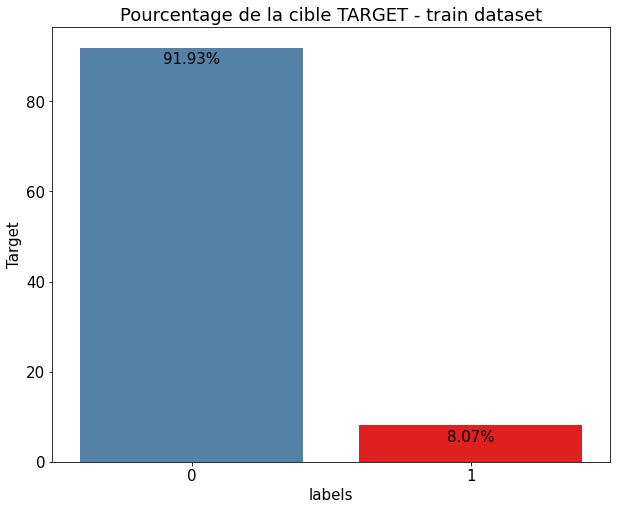

In [32]:
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'Target': temp.values/temp.values.sum()*100
                  })
plt.figure(figsize = (10,8))
plt.title('Pourcentage de la cible TARGET - train dataset')
# sns.set_color_codes("pastel")
plot = sns.barplot(x = 'labels', y = "Target", data = df, palette = ['Steelblue', 'red'])
locs, labels = plt.xticks()

# add percentage annotation

for p in plot.patches :
    plot.annotate('{:.2f}%'.format(p.get_height()), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size = 15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')
    
plt.savefig('target percentage', dpi=200, bbox_inches='tight') 
plt.show()              
 

#### Comme one peut le constater les 2 classes 0 et 1 sont fortement désequilibrés avec 91.9% des clients non-défaillants et 8% seulement des clients défaillants avec un défaut de paiement ou plus. Il faut prendre ce désequilibre en compte dans la classification

-------------------------------------------------------------------------------------------------------------------------------

Le premier aprecu des données montre clairement un dataset complexe et volumineux (7 tables avec 221 variables). Il nous a été recommandé d'utiliser un kernel kaggle pour le prétraitement des données et le feature engineering. Mon choix a été porté sur le kernel de Mr. WILL KOEHRSEN, un des participants a la compétition, et qui a utilisé plusieurs techniques manuelles et automatiques de feature engineeering avec détails et comparaison des résultats.   
source: https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

-------------------------------------------------------------------------------------------------------------------------------

### Dans la suite, je commence par l'exploration et traitement de la table principale des demandes de prêts qui est "application"

Dans cette partie, les jeu de données d'entrainement (application_train) et de test  (application_test) sont concaténés pour pouvoir traiter les features de manière conjointe. On ajoute une colonne 'test' d'identification des 2 sets


In [4]:
# Merge jeu d'entrainement et jeu de test
df_app_tot = p7_functions.merge_train_test(application_train, application_test)


In [14]:
display(df_app_tot.head())
display(df_app_tot.shape)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002     1.0         Cash loans           M            N   
1      100003     0.0         Cash loans           F            N   
2      100004     0.0    Revolving loans           M            Y   
3      100006     0.0         Cash loans           F            N   
4      100007     0.0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

(356255, 123)

Au total, nous avons 122 variables et 356255 clients (enregistrement de demande de prêt)

### Variables catégorielles

In [13]:
cat = list(df_app_tot.dtypes[df_app_tot.dtypes == np.object].index)
cat 

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [24]:
# Descriptif des variables catégorielles dans train et test sets
cat = list(df_app_tot.dtypes[df_app_tot.dtypes == np.object].index)
print(f"Nombre des colonnes categorielles : {len(cat)}")
p7_functions.display_uniq_cat(df_app_tot)

Nombre des colonnes categorielles : 16
NAME_CONTRACT_TYPE
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['Cash loans', 'Revolving loans']
Unique in Test:  ['Cash loans', 'Revolving loans']


CODE_GENDER
Number Unique in Train: 3
Number Unique in Test:  2
Unique in Train:  ['F', 'M', 'XNA']
Unique in Test:  ['F', 'M']


FLAG_OWN_CAR
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


FLAG_OWN_REALTY
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


NAME_TYPE_SUITE
Number Unique in Train: 7
Number Unique in Test:  7
Unique in Train:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']
Unique in Test:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']


NAME_INCOME_TYPE
Number Unique in Train: 8
Number Unique in Test:  7
Unique in Train:

----------------------------------------------------------------------------------------------------------------------------
On peut constater qu'il y a des valeurs dans train qui ne sont pas dans test comme :   
'XNA' dans CODE_GENDER  
'Maternity leave' dans NAME_INCOME_TYPE    
'Unknown' dans NAME_FAMILY_STATUS   
Pour toutes les autres variables catégorielles nous avons les memes valeurs dans les 2 sets. Est ce que ces valeurs sont nombreuses?
----------------------------------------------------------------------------------------------------------------------------------


In [40]:
df_app_tot.loc[df_app_tot['CODE_GENDER'] == 'XNA']

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
35657       141289     0.0    Revolving loans         XNA            Y   
38566       144669     0.0    Revolving loans         XNA            N   
83382       196708     0.0    Revolving loans         XNA            N   
189640      319880     0.0    Revolving loans         XNA            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
35657                Y             0          207000.0    382500.0   
38566                Y             2          157500.0    270000.0   
83382                Y             1          135000.0    405000.0   
189640               Y             0          247500.0    540000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
35657       19125.0         337500.0   Unaccompanied               Working   
38566       13500.0         225000.0          Family               Working   
83382       20250.0         225000.0   Unaccompanied               Working   
189640      27000.0         900000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
35657   Secondary / secondary special            Married  Municipal apartment   
38566   Secondary / secondary special            Married    House / apartment   
83382                Higher education            Married    House / apartment   
189640              Incomplete higher     Civil marriage    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
35657                     0.020713      -20232         -10044   
38566                     0.026392      -13717          -2797   
83382                     0.035792      -10647          -1228   
189640                    0.035792       -9649          -2293   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
35657            -10024.0            -3537         13.0           1   
38566             -2241.0            -4659          NaN           1   
83382              -183.0            -1671          NaN           1   
189640            -4099.0            -2326          8.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
35657                1                1                 1           1   
38566                1                1                 1           1   
83382                1                1                 1           1   
189640               1                1                 1           1   

        FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
35657            0                 NaN              2.0                     3   
38566            0  Low-skill Laborers              4.0                     2   
83382            0          Core staff              3.0                     2   
189640           0                 NaN              2.0                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
35657                             3                    TUESDAY   
38566                             2                     FRIDAY   
83382                             2                   THURSDAY   
189640                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
35657                        10                           0   
38566                        16                           0   
83382                        15                           0   
189640                       15                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
35657                            0                            0   
38566                            0                            0   
83382                            0                            0   
189640                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CI

In [41]:
df_app_tot.loc[df_app_tot['NAME_INCOME_TYPE'] == 'Maternity leave' ]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
48949       156685     0.0    Revolving loans           M            N   
109612      227123     0.0    Revolving loans           F            N   
218269      352877     1.0         Cash loans           F            N   
291432      437628     1.0         Cash loans           F            Y   
295458      442305     0.0    Revolving loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
48949                N             0          360000.0    765000.0   
109612               Y             2          135000.0    810000.0   
218269               Y             2           67500.0   1435500.0   
291432               Y             2           49500.0    423000.0   
295458               Y             1           90000.0    315000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE NAME_INCOME_TYPE  \
48949       76500.0         765000.0    Unaccompanied  Maternity leave   
109612      40500.0         810000.0  Spouse, partner  Maternity leave   
218269      40896.0        1435500.0    Unaccompanied  Maternity leave   
291432      11286.0         423000.0  Spouse, partner  Maternity leave   
295458      15750.0         315000.0    Unaccompanied  Maternity leave   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
48949                Higher education            Married  House / apartment   
109612               Higher education            Married  House / apartment   
218269  Secondary / secondary special            Married  House / apartment   
291432  Secondary / secondary special            Married  House / apartment   
295458               Higher education            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
48949                     0.046220      -22166          -3762   
109612                    0.030755      -14943          -1223   
218269                    0.006852      -13121          -3629   
291432                    0.031329      -14363          -3020   
295458                    0.001276       -9519          -1550   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
48949             -9228.0            -4363          NaN           1   
109612            -8853.0            -3868          NaN           1   
218269             -795.0            -1007          NaN           1   
291432             -419.0            -4333          8.0           1   
295458            -4266.0             -768          NaN           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
48949                1                0                 1           1   
109612               1                0                 1           0   
218269               1                0                 1           0   
291432               1                0                 1           0   
295458               1                0                 1           1   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
48949            0             NaN              2.0                     1   
109612           0      Core staff              4.0                     2   
218269           0        Laborers              4.0                     3   
291432           0      Core staff              4.0                     2   
295458           0     Accountants              3.0                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
48949                             1                   THURSDAY   
109612                            2                    TUESDAY   
218269                            3                    TUESDAY   
291432                            2                     MONDAY   
295458                            2                     MONDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
48949                        19           

In [42]:
df_app_tot.loc[df_app_tot['NAME_FAMILY_STATUS'] == 'Unknown' ]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
41982       148605     0.0    Revolving loans           M            N   
187348      317181     0.0    Revolving loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
41982                Y             0          450000.0    675000.0   
187348               Y             0          202500.0    585000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
41982       33750.0              NaN             NaN  Commercial associate   
187348      29250.0              NaN             NaN  Commercial associate   

       NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
41982      Lower secondary            Unknown  Municipal apartment   
187348    Higher education            Unknown    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
41982                     0.015221      -12396          -1161   
187348                    0.031329      -12844           -232   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
41982             -3265.0            -4489          NaN           1   
187348            -1597.0            -1571          NaN           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
41982                1                1                 1           1   
187348               1                0                 1           0   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
41982            0        Managers              NaN                     2   
187348           0     Accountants              NaN                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
41982                             2                   THURSDAY   
187348                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
41982                        15                           0   
187348                       14                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
41982                            1                            1   
187348                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
41982                        0                       1   
187348                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
41982                         1               Insurance      0.628564   
187348                        0  Business Entity Type 2           NaN   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
41982       0.700618           NaN             NaN               NaN   
187348      0.645168      0.670652          0.1031            0.0467   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
41982                           NaN              NaN             NaN   
187348                        0.997           0.9592          0.0081   

        ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
41982             NaN            NaN            NaN            NaN   
187348           0.08          0.069          0.375         0.4167   

        LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
41982            NaN                   NaN             NaN   
187348           NaN                0.0841           0.088   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
41982                       NaN                NaN              NaN   
187348                      0.0                0.0            0.105   

        BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
41982                 NaN                           NaN               NaN   
187348             0.0485                         0.997            0.9608   

  

On va supprimer les données correspondant a ces valeurs qui sont au totales 11 SK_ID_CURR et cela n'affectera pas les données

In [43]:
df_app_tot.shape

(356255, 123)

In [6]:
# Supprimer les individus dont le genre est 'XNA', dont 'NAME_INCOME_TYPE' vient d'un congé maternité et dont la statut familial est inconnu
df_app_tot = df_app_tot[(df_app_tot['CODE_GENDER'] != 'XNA') & (df_app_tot['NAME_INCOME_TYPE'] != 'Maternity leave') & (df_app_tot['NAME_FAMILY_STATUS'] != 'Unknown')]

#### Variable 'OCCUPATION_TYPE'

Total Number of unique categories of OCCUPATION_TYPE = 19


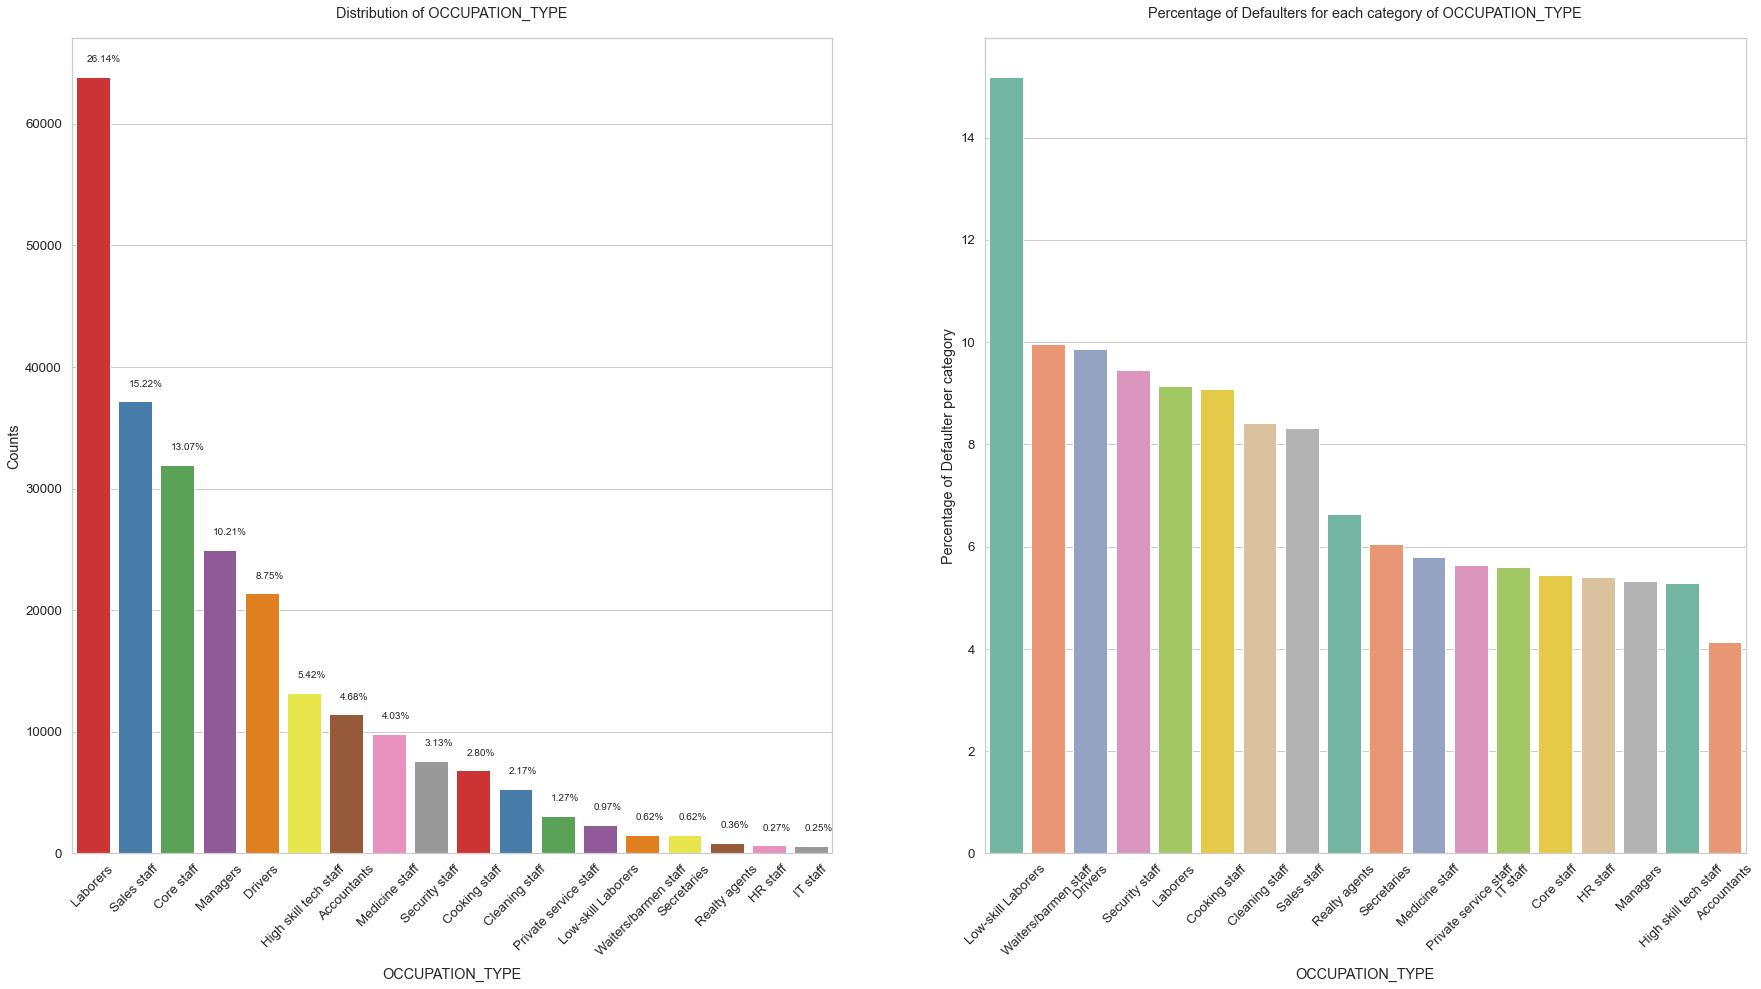

In [158]:
#plotting the Bar Plot for the Column 'OCCUPATION_TYPE'
#plot_categorical_variables_bar(df_app_tot, column_name = 'OCCUPATION_TYPE', rotation = 45, horizontal_adjust = 0.25 , figsize = (30,15))
p7_functions.bar_plt_cat_var(df_app_tot, column_name = 'OCCUPATION_TYPE', rotation = 45, horizontal_adjust = 0.25 , figsize = (30,15))

#### Variable 'NAME_EDUCATION_TYPE'

Total Number of unique categories of NAME_EDUCATION_TYPE = 5


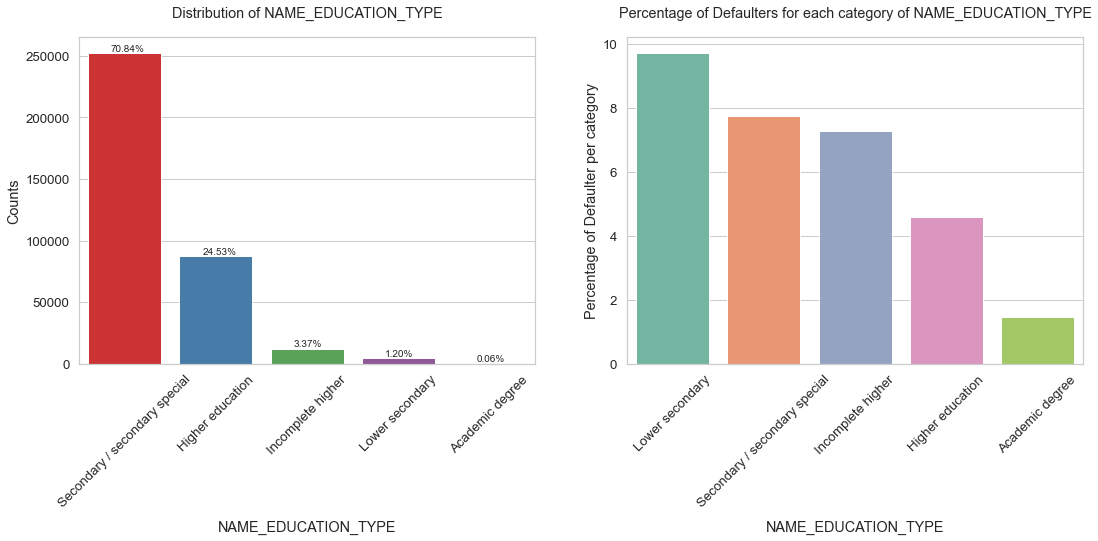

In [149]:
# plotting the Bar Plot for the Column 'NAME_EDUCATION_TYPE'
p7_functions.bar_plt_cat_var(df_app_tot, column_name = 'NAME_EDUCATION_TYPE', rotation = 45, horizontal_adjust = 0.25)

#### Variable NAME_FAMILY_STATUS

Total Number of unique categories of NAME_FAMILY_STATUS = 5


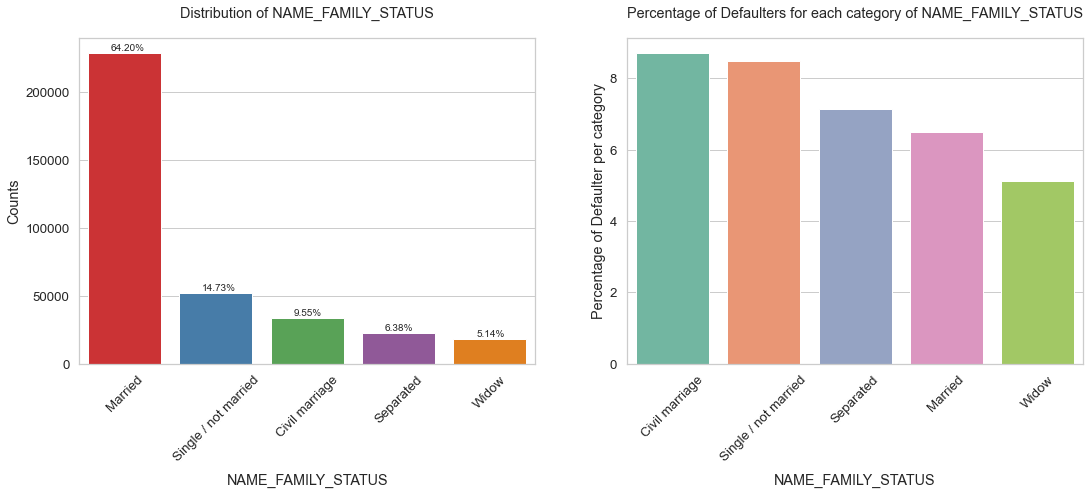

In [159]:
# plotting the Bar Plot for the Column 'NAME_FAMILY_STATUS'
p7_functions.bar_plt_cat_var(df_app_tot, column_name = 'NAME_FAMILY_STATUS', rotation = 45, horizontal_adjust = 0.25)

#### Variable 'FLAG_OWN_REALTY '

Total Number of unique categories of FLAG_OWN_REALTY = 2


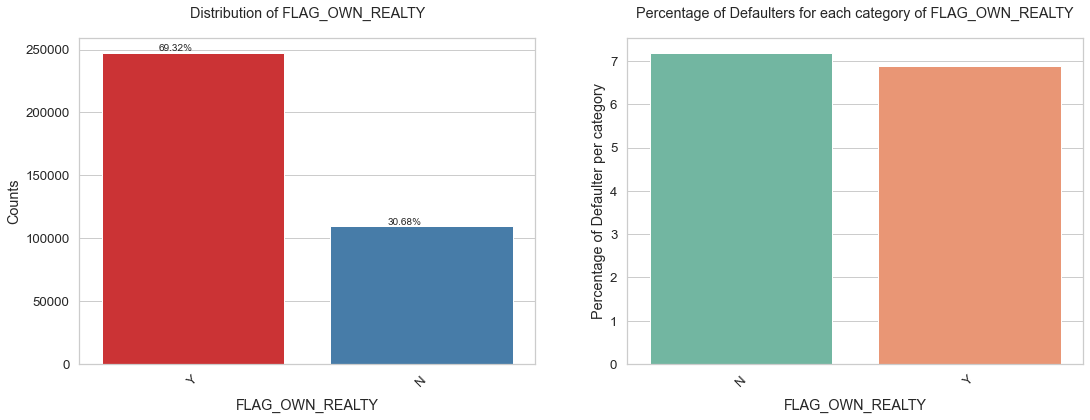

In [160]:
# plotting the Bar Plot for the Column 'FLAG_OWN_REALTY'
p7_functions.bar_plt_cat_var(df_app_tot, column_name = 'FLAG_OWN_REALTY', rotation = 45, horizontal_adjust = 0.25)

#### Variable 'NAME_HOUSING_TYPE'

Total Number of unique categories of NAME_HOUSING_TYPE = 6


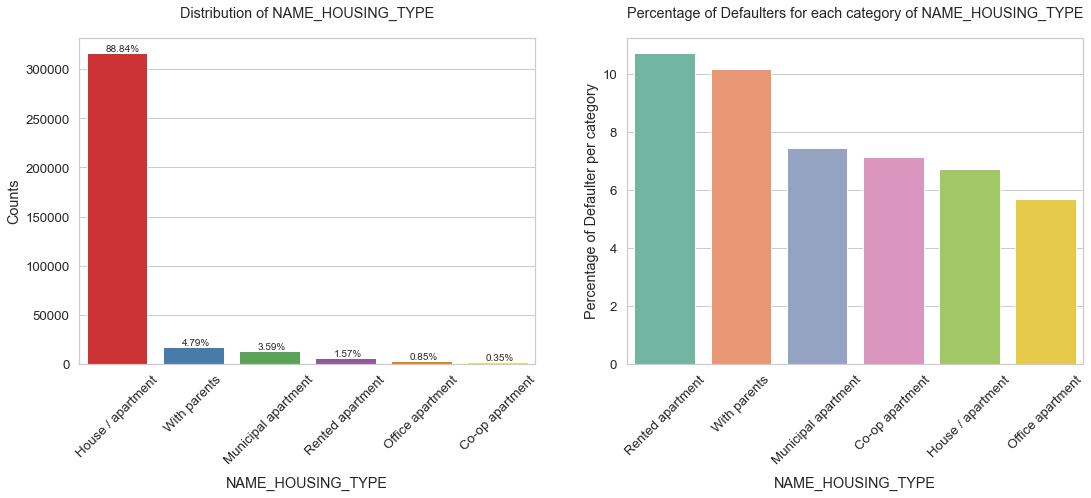

In [161]:
#plotting the Bar Plot for the Column 'NAME_HOUSING_TYPE'
p7_functions.bar_plt_cat_var(df_app_tot, column_name = 'NAME_HOUSING_TYPE', rotation = 45, horizontal_adjust = 0.25)

### Variables numériques

### Anomalies

In [29]:
df_app_tot.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  356244.000000  307500.000000  356244.000000      3.562440e+05   
mean   278128.489715       0.080725       0.414300      1.701154e+05   
std    102841.801434       0.272413       0.720367      2.235093e+05   
min    100001.000000       0.000000       0.000000      2.565000e+04   
25%    189065.750000       0.000000       0.000000      1.125000e+05   
50%    278128.500000       0.000000       0.000000      1.530000e+05   
75%    367192.250000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      20.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.562440e+05  356208.000000     3.559680e+05   
mean   5.877670e+05   27425.487312     5.280181e+05   
std    3.986260e+05   14732.700746     3.660643e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16731.000000     2.340000e+05   
50%    5.002110e+05   25078.500000     4.500000e+05   
75%    7.975575e+05   34960.500000     6.750000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               356244.000000  356244.000000  356244.000000   
mean                     0.020917  -16041.313002   64319.304230   
std                      0.013915    4358.803965  141707.228656   
min                      0.000253  -25229.000000  -17912.000000   
25%                      0.010006  -19676.000000   -2781.000000   
50%                      0.018850  -15755.000000   -1224.000000   
75%                      0.028663  -12425.000000    -290.000000   
max                      0.072508   -7338.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      356244.000000    356244.000000  121011.000000  356244.000000   
mean        -4983.621175     -3002.072372      12.023799       0.999994   
std          3526.966509      1517.904029      11.880983       0.002369   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7477.000000     -4318.000000       5.000000       1.000000   
50%         -4502.000000     -3252.000000       9.000000       1.000000   
75%         -1995.000000     -1717.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   356244.000000    356244.000000     356244.000000  356244.000000   
mean         0.818492         0.200090          0.998170       0.278601   
std          0.385439         0.400068          0.042742       0.448311   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  356244.000000    356244.000000         356244.000000   
mean        0.071215         2.151834              2.050505   
std         0.257184         0.907925              0.510947   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        21.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                356244.000000            356244.000000   
mean                      2.028930                12.055684   
std                       0.504586                 3.267572   
min                      -1.000000                 0.000000   
25%                       

On peut constater que plusieurs variables contiennent des valeurs aberrantes comme AMT_INCOME_TOTAL de 100 millions dollars pour un demandeur de credit (pourquoi pas!). On va traiter celles qui sont évidentes comme l'age et la durée d'emploi actuel. 

In [50]:
# DAYS_BIRTH
(df_app_tot['DAYS_BIRTH'] / -365).describe()

count    356244.000000
mean         43.948803
std          11.941929
min          20.104110
25%          34.041096
50%          43.164384
75%          53.906849
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [52]:
(df_app_tot['DAYS_EMPLOYED'] / -365).describe()

count    356244.000000
mean       -176.217272
std         388.238983
min       -1000.665753
25%           0.794521
50%           3.353425
75%           7.619178
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [8]:
anom_days_emp = df_app_tot.loc[df_app_tot['DAYS_EMPLOYED'] > 0]
anom_values = anom_days_emp['DAYS_EMPLOYED'].unique()
print(len(anom_days_emp))
print(anom_values)

64648
[365243]


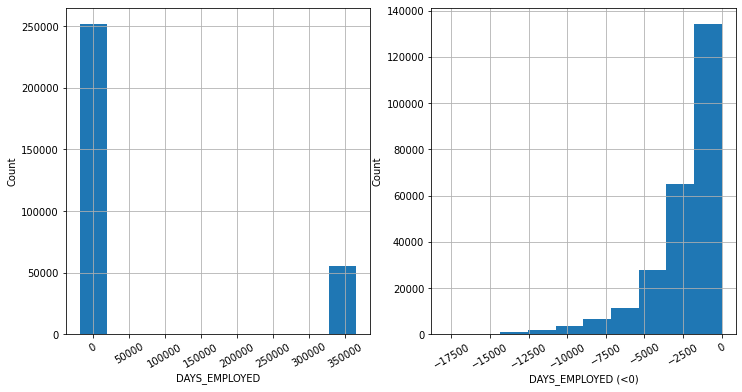

In [83]:
# Affiche l'histogramme du nombre de jours employés
fig = plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
application_train['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.xticks(rotation = 30)

# Affiche l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
#df_app_tot.loc[df_app_tot['DAYS_EMPLOYED'] < 0, 'DAYS_EMPLOYED'].hist()
application_train.loc[application_train['DAYS_EMPLOYED'] < 50000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (<0)')
plt.ylabel('Count')
plt.xticks(rotation = 30)
plt.show()

Toutes les valeurs positives sont aberrantes. Remplacer-les par NaN 

In [9]:
# Remplace la valeur abérrante par NaN
df_app_tot['DAYS_EMPLOYED'].replace(anom_values, np.nan, inplace = True)


### Valeurs manquantes


In [30]:
miss_app = p7_functions.missing_data(df_app_tot)
miss_app


Total    Percent
COMMONAREA_MEDI               248360  69.714109
COMMONAREA_AVG                248360  69.714109
COMMONAREA_MODE               248360  69.714109
NONLIVINGAPARTMENTS_MEDI      246861  69.293343
NONLIVINGAPARTMENTS_MODE      246861  69.293343
NONLIVINGAPARTMENTS_AVG       246861  69.293343
FONDKAPREMONT_MODE            243092  68.235393
LIVINGAPARTMENTS_AVG          242979  68.203674
LIVINGAPARTMENTS_MODE         242979  68.203674
LIVINGAPARTMENTS_MEDI         242979  68.203674
FLOORSMIN_MODE                241108  67.678489
FLOORSMIN_AVG                 241108  67.678489
FLOORSMIN_MEDI                241108  67.678489
YEARS_BUILD_MEDI              236306  66.330578
YEARS_BUILD_AVG               236306  66.330578
YEARS_BUILD_MODE              236306  66.330578
OWN_CAR_AGE                   235241  66.031635
LANDAREA_AVG                  210844  59.183450
LANDAREA_MODE                 210844  59.183450
LANDAREA_MEDI                 210844  59.183450
BASEMENTAREA_MODE             207584  58.268375
BASEMENTAREA_MEDI             207584  58.268375
BASEMENTAREA_AVG              207584  58.268375
NONLIVINGAREA_AVG             195766  54.951088
NONLIVINGAREA_MODE            195766  54.951088
NONLIVINGAREA_MEDI            195766  54.951088
EXT_SOURCE_1                  193910  54.430113
ELEVATORS_MODE                189080  53.074343
ELEVATORS_MEDI                189080  53.074343
ELEVATORS_AVG                 189080  53.074343
WALLSMATERIAL_MODE            180234  50.591290
APARTMENTS_MODE               179948  50.511010
APARTMENTS_MEDI               179948  50.511010
APARTMENTS_AVG                179948  50.511010
ENTRANCES_AVG                 178407  50.078455
ENTRANCES_MEDI                178407  50.078455
ENTRANCES_MODE                178407  50.078455
HOUSETYPE_MODE                177916  49.940632
LIVINGAREA_MODE               177902  49.936703
LIVINGAREA_MEDI               177902  49.936703
LIVINGAREA_AVG                177902  49.936703
FLOORSMAX_MEDI                176341  49.498533
FLOORSMAX_AVG                 176341  49.498533
FLOORSMAX_MODE                176341  49.498533
YEARS_BEGINEXPLUATATION_MEDI  172863  48.522266
YEARS_BEGINEXPLUATATION_AVG   172863  48.522266
YEARS_BEGINEXPLUATATION_MODE  172863  48.522266
TOTALAREA_MODE                171055  48.014765
EMERGENCYSTATE_MODE           167964  47.147128
OCCUPATION_TYPE               111996  31.437032
EXT_SOURCE_3                   69633  19.545831
TARGET                         48744  13.682334
AMT_REQ_CREDIT_BUREAU_HOUR     47568  13.352234
AMT_REQ_CREDIT_BUREAU_YEAR     47568  13.352234
AMT_REQ_CREDIT_BUREAU_QRT      47568  13.352234
AMT_REQ_CREDIT_BUREAU_MON      47568  13.352234
AMT_REQ_CREDIT_BUREAU_WEEK     47568  13.352234
AMT_REQ_CREDIT_BUREAU_DAY      47568  13.352234
NAME_TYPE_SUITE                 2203   0.618377
OBS_30_CNT_SOCIAL_CIRCLE        1050   0.294733
DEF_30_CNT_SOCIAL_CIRCLE        1050   0.294733
DEF_60_CNT_SOCIAL_CIRCLE        1050   0.294733
OBS_60_CNT_SOCIAL_CIRCLE        1050   0.294733
EXT_SOURCE_2                     668   0.187506
AMT_GOODS_PRICE                  278   0.078034
AMT_ANNUITY                       36   0.010105
CNT_FAM_MEMBERS                    2   0.000561
DAYS_LAST_PHONE_CHANGE             1   0.000281
FLAG_DOCUMENT_20                   0   0.000000
FLAG_DOCUMENT_21                   0   0.000000
FLAG_DOCUMENT_2                    0   0.000000
FLAG_DOCUMENT_6                    0   0.000000
FLAG_DOCUMENT_19                   0   0.000000
FLAG_DOCUMENT_7                    0   0.000000
FLAG_DOCUMENT_3                    0   0.000000
FLAG_DOCUMENT_17                   0   0.000000
FLAG_DOCUMENT_16                   0   0.000000
FLAG_DOCUMENT_15                   0   0.000000
FLAG_DOCUMENT_4                    0   0.000000
FLAG_DOCUMENT_14                   0   0.000000
FLAG_DOCUMENT_13                   0   0.000000
FLAG_DOCUMENT_5                    0   0.000000
FLAG_DOCUMENT_12                   0   0.000000

In [31]:
print(f"il y a {len(miss_app.loc[miss_app['Percent'] > 0])} colonnes dans application avec des valeurs manquantes")

il y a 68 colonnes dans application_test avec des valeurs manquantes


Pour la partie modélisation, certains modèles de machine learning ne gerent pas les valeurs manquantes. Il faut donc les traiter et supprimer les colonnes avec un pourcentage élevé de valeurs manquantes. Pour le moment, on conserve toutes les colonnes pour comprendre mieux leur utilité dans la classification.

## Encodage des variables catégorielles

Comme la plupart des modeles ML ne traitent pas les variables catégorielles (certains le font comme lightgbm par exemple), on va les encoder:     
- Celles avec 2 valeurs encodage avec label encoder     
- Celles avec plus de valeurs encodage avec One Hot Encoder  

In [29]:
# Encoder les variables de type object avec des 2 valeurs en boolean
for col in df_app_tot :
    # encode col en boolean si type object et si 2 valeurs 
    if (df_app_tot[col].dtype != 'object') and (len(df_app_tot[col].unique()) <= 2):  
        df_app_tot[col] = df_app_tot[col].astype('bool')


In [295]:
df_app = df_app_tot.copy()
df_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356244 entries, 100002 to 456250
Columns: 123 entries, SK_ID_CURR to Test
dtypes: bool(33), category(16), float64(67), int64(7)
memory usage: 220.5 MB


In [296]:
var_type_keep = ['bool', 'float64', 'int64']
new_var_type = 'object'
df_app = p7_functions.change_var_type(df_app, var_type_keep, new_var_type)
df_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356244 entries, 100002 to 456250
Columns: 123 entries, SK_ID_CURR to Test
dtypes: bool(33), float64(67), int64(7), object(16)
memory usage: 258.5+ MB


In [298]:
%%time
df_app_enc = p7_functions.cat_encoder(df_app)
df_app_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356244 entries, 100002 to 456250
Columns: 239 entries, SK_ID_CURR to WALLSMATERIAL_MODE_Wooden
dtypes: bool(33), float64(74), int32(5), uint8(127)
memory usage: 265.0 MB
Wall time: 1.58 s


In [253]:
df_app_enc.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
100002    100002.0     1.0                   0            1             0   
100003    100003.0     0.0                   0            0             0   
100004    100004.0     0.0                   1            1             1   
100006    100006.0     0.0                   0            0             0   
100007    100007.0     0.0                   0            1             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
100002                1           0.0          202500.0    406597.5   
100003                0           0.0          270000.0   1293502.5   
100004                1           0.0           67500.0    135000.0   
100006                1           0.0          135000.0    312682.5   
100007                1           0.0          121500.0    513000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
100002      24700.5         351000.0                    0.018801     -9461.0   
100003      35698.5        1129500.0                    0.003541    -16765.0   
100004       6750.0         135000.0                    0.010032    -19046.0   
100006      29686.5         297000.0                    0.008019    -19005.0   
100007      21865.5         513000.0                    0.028663    -19932.0   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
100002         -637.0            -3648.0          -2120.0          NaN   
100003        -1188.0            -1186.0           -291.0          NaN   
100004         -225.0            -4260.0          -2531.0         26.0   
100006        -3039.0            -9833.0          -2437.0          NaN   
100007        -3038.0            -4311.0          -3458.0          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
100002        True            True            False              True   
100003        True            True            False              True   
100004        True            True             True              True   
100006        True            True            False              True   
100007        True            True            False              True   

        FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
100002        True       False              1.0                   2.0   
100003        True       False              2.0                   1.0   
100004        True       False              1.0                   2.0   
100006       False       False              2.0                   2.0   
100007       False       False              1.0                   2.0   

        REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
100002                          2.0                     10.0   
100003                          1.0                     11.0   
100004                          2.0                      9.0   
100006                          2.0                     17.0   
100007                          2.0                     11.0   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
100002                       False                       False   
100003                       False                       False   
100004                       False                       False   
100006                       False                       False   
100007                       False                       False   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
100002                        False                   False   
100003                        False                   False   
100004                        False                   False   
100006                        False                   False   
100007                        False                   False   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
100002                   False                    False      0.083037   
100003 

Avant de passer a la partie feature engineering, je vais faire une premiere prédiction avec le model lightGBM sur le fichier pre_traité "train_app" pour pouvoir ensuite mieux comprendre la contribution et l'importance de feature engineering dans la classification. le modèle a été choisi pour sa performance et sa rapidité. Il sera entrainé sur train_app séparé en plusieurs folds (cross validation). Le déséquilibre des classes est pris en compte dans l’entraînement du modèle via l'hyperparamètre class_weight = 'balanced'. La métrique d’évaluation est AUC calculée sur le pli de validation. l'AUC est communément utilisé avec les classifieurs binaires non équilibrés. Elle croise le taux de True positive (TP) avec le taux de False positive (FP) et consiste à mesurer l’aire sous la courbe. Un classifieur parfait aurait un score AUC égal à 1, tandis qu’un classifieur purement aléatoire aurait un score AUC de 0.5.

### Prédiction avec LightGBM (application table)

### Séparation du train et test sets 

In [269]:
# récuperer test et train
train_app, test_app = p7_functions.get_train(df_app_enc)

In [272]:
train_app.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0    100002.0     1.0                   0            1             0   
1    100003.0     0.0                   0            0             0   
2    100004.0     0.0                   1            1             1   
3    100006.0     0.0                   0            0             0   
4    100007.0     0.0                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1           0.0          202500.0    406597.5      24700.5   
1                0           0.0          270000.0   1293502.5      35698.5   
2                1           0.0           67500.0    135000.0       6750.0   
3                1           0.0          135000.0    312682.5      29686.5   
4                1           0.0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801     -9461.0         -637.0   
1        1129500.0                    0.003541    -16765.0        -1188.0   
2         135000.0                    0.010032    -19046.0         -225.0   
3         297000.0                    0.008019    -19005.0        -3039.0   
4         513000.0                    0.028663    -19932.0        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0          -2120.0          NaN        True   
1            -1186.0           -291.0          NaN        True   
2            -4260.0          -2531.0         26.0        True   
3            -9833.0          -2437.0          NaN        True   
4            -4311.0          -3458.0          NaN        True   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0            True            False              True        True       False   
1            True            False              True        True       False   
2            True             True              True        True       False   
3            True            False              True       False       False   
4            True            False              True       False       False   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                   2.0                          2.0   
1              2.0                   1.0                          1.0   
2              1.0                   2.0                          2.0   
3              2.0                   2.0                          2.0   
4              1.0                   2.0                          2.0   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                     10.0                       False   
1                     11.0                       False   
2                      9.0                       False   
3                     17.0                       False   
4                     11.0                       False   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                   False                   False                    False   
1                   False                   False                    False   
2                   False                   False                    False   
3                   False                   False                    False   
4                   False                    True                     True   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376

In [271]:
train_app = train_app.reset_index(drop=True)
test_app = test_app.reset_index(drop=True)

In [273]:
%%time
submission_app, fi_app, metrics_app = p7_functions.model(train_app, test_app, n_folds = 5)

Training Data Shape:  (307500, 236)
Testing Data Shape:  (48744, 236)
[200]	train's auc: 0.798837	train's binary_logloss: 0.547842	valid's auc: 0.759858	valid's binary_logloss: 0.562064
[400]	train's auc: 0.831072	train's binary_logloss: 0.515617	valid's auc: 0.761035	valid's binary_logloss: 0.542336
[200]	train's auc: 0.799836	train's binary_logloss: 0.546889	valid's auc: 0.756954	valid's binary_logloss: 0.560486
[200]	train's auc: 0.799169	train's binary_logloss: 0.547598	valid's auc: 0.759061	valid's binary_logloss: 0.564289
[400]	train's auc: 0.831791	train's binary_logloss: 0.515035	valid's auc: 0.759537	valid's binary_logloss: 0.544093
[200]	train's auc: 0.798433	train's binary_logloss: 0.547994	valid's auc: 0.761196	valid's binary_logloss: 0.566127
[400]	train's auc: 0.830927	train's binary_logloss: 0.515503	valid's auc: 0.761637	valid's binary_logloss: 0.54625
[200]	train's auc: 0.798907	train's binary_logloss: 0.547754	valid's auc: 0.759321	valid's binary_logloss: 0.56467
Wall

In [274]:
metrics_app

fold     train     valid
0        0  0.838376  0.761336
1        1  0.814263  0.757763
2        2  0.821052  0.759670
3        3  0.820504  0.761707
4        4  0.813525  0.760051
5  overall  0.821544  0.760046

### Pour ce premier test de classification avec lightGBM, on obtient un score AUC de 0.76

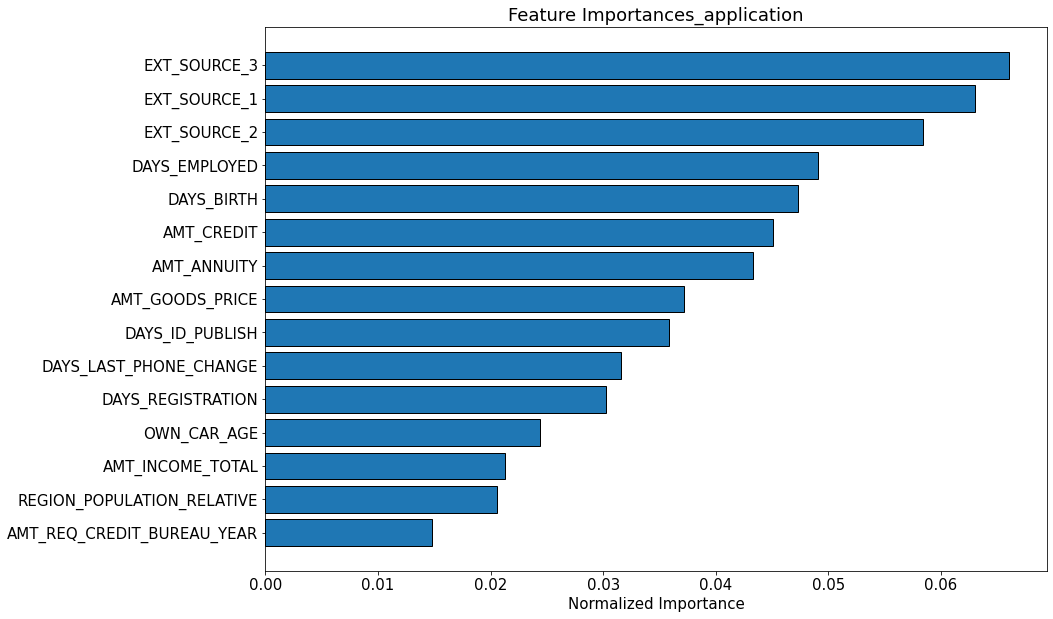

In [287]:
p7_functions.plot_feature_importances(fi_app, 'application')
plt.savefig('Feature Imp test app', dpi=200, bbox_inches='tight') 
plt.show()


## Feature engineering

### Feature Engineering (FE) manuel

Dans cette étape, on va créer manuellement de nouvelles features pertinentes issues de celles existantes pour aider le modèle

In [294]:
def manual_feature_engineering(df) :
    
    app = df.copy()
    # ratio temps travaillé/âge
    app['PROPORTION_LIFE_EMPLOYED'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']
    # ratio crédit/revenu
    app['INCOME_TO_CREDIT_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_CREDIT'] 
    # ratio revenu/annuité
    app['INCOME_TO_ANNUITY_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_ANNUITY']
    # ratio revenu/annuité/âge
    app['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = app['INCOME_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']/(-365)
    # ratio crédit/annuité
    app['CREDIT_TO_ANNUITY_RATIO'] = app['AMT_CREDIT'] / app['AMT_ANNUITY']
    # ratio crédit/annuité/âge
    app['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = app['CREDIT_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']/(-365)
    app['INCOME_TO_FAMILYSIZE_RATIO'] = app['AMT_INCOME_TOTAL'] / app['CNT_FAM_MEMBERS']
    
    return app

In [300]:
df_app_FE = manual_feature_engineering(df_app_enc)

## Prédiction avec LightGBM (application table+ FE manuel)

In [304]:
# recuperer test et train
train_app_FE, test_app_FE = p7_functions.get_train(df_app_FE)

In [307]:
train_app_FE.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0    100002.0     1.0                   0            1             0   
1    100003.0     0.0                   0            0             0   
2    100004.0     0.0                   1            1             1   
3    100006.0     0.0                   0            0             0   
4    100007.0     0.0                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1           0.0          202500.0    406597.5      24700.5   
1                0           0.0          270000.0   1293502.5      35698.5   
2                1           0.0           67500.0    135000.0       6750.0   
3                1           0.0          135000.0    312682.5      29686.5   
4                1           0.0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801     -9461.0         -637.0   
1        1129500.0                    0.003541    -16765.0        -1188.0   
2         135000.0                    0.010032    -19046.0         -225.0   
3         297000.0                    0.008019    -19005.0        -3039.0   
4         513000.0                    0.028663    -19932.0        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0          -2120.0          NaN        True   
1            -1186.0           -291.0          NaN        True   
2            -4260.0          -2531.0         26.0        True   
3            -9833.0          -2437.0          NaN        True   
4            -4311.0          -3458.0          NaN        True   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0            True            False              True        True       False   
1            True            False              True        True       False   
2            True             True              True        True       False   
3            True            False              True       False       False   
4            True            False              True       False       False   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                   2.0                          2.0   
1              2.0                   1.0                          1.0   
2              1.0                   2.0                          2.0   
3              2.0                   2.0                          2.0   
4              1.0                   2.0                          2.0   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                     10.0                       False   
1                     11.0                       False   
2                      9.0                       False   
3                     17.0                       False   
4                     11.0                       False   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                   False                   False                    False   
1                   False                   False                    False   
2                   False                   False                    False   
3                   False                   False                    False   
4                   False                    True                     True   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376

In [306]:
train_app_FE = train_app_FE.reset_index(drop = True)
test_app_FE = test_app_FE.reset_index(drop = True)

In [308]:
%%time
submission_app_FE, fi_app_FE, metrics_app_FE = p7_functions.model(train_app_FE, test_app_FE, n_folds = 5)

Training Data Shape:  (307500, 243)
Testing Data Shape:  (48744, 243)
[200]	train's auc: 0.80501	train's binary_logloss: 0.54132	valid's auc: 0.766262	valid's binary_logloss: 0.556431
[400]	train's auc: 0.837719	train's binary_logloss: 0.507755	valid's auc: 0.76717	valid's binary_logloss: 0.536044
[200]	train's auc: 0.805586	train's binary_logloss: 0.540898	valid's auc: 0.765372	valid's binary_logloss: 0.554534
[200]	train's auc: 0.806027	train's binary_logloss: 0.540581	valid's auc: 0.765725	valid's binary_logloss: 0.558135
[400]	train's auc: 0.83869	train's binary_logloss: 0.507093	valid's auc: 0.767379	valid's binary_logloss: 0.537416
[200]	train's auc: 0.805078	train's binary_logloss: 0.541328	valid's auc: 0.768137	valid's binary_logloss: 0.559888
[200]	train's auc: 0.805993	train's binary_logloss: 0.540217	valid's auc: 0.766876	valid's binary_logloss: 0.559078
Wall time: 2min 53s


In [309]:
metrics_app_FE

fold     train     valid
0        0  0.835568  0.767410
1        1  0.814485  0.766221
2        2  0.828305  0.767642
3        3  0.816252  0.768740
4        4  0.819368  0.767545
5  overall  0.822796  0.767444

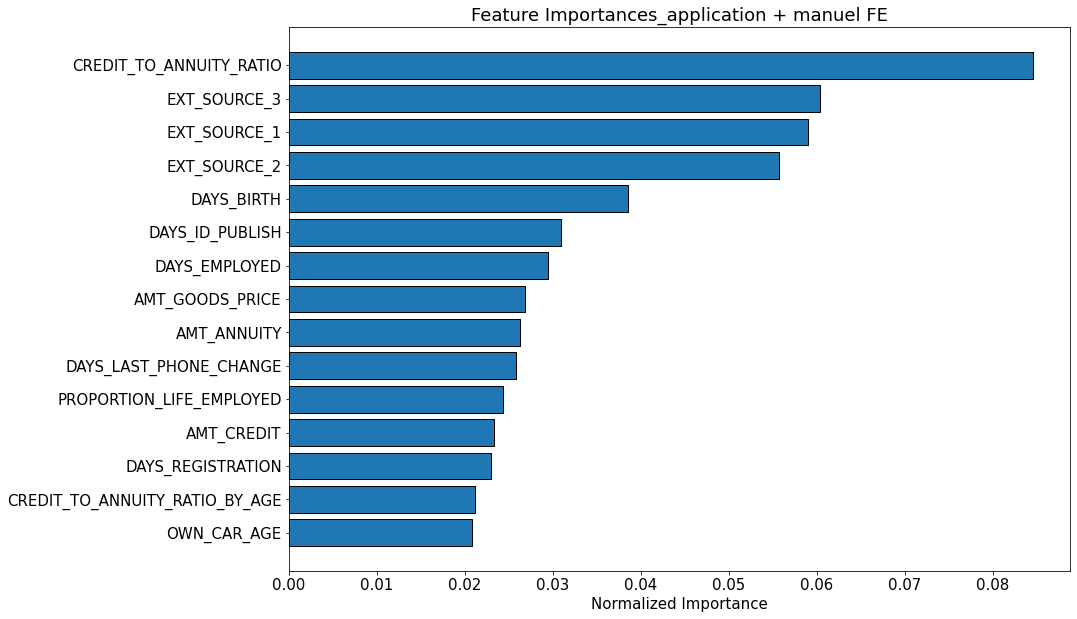

In [310]:
p7_functions.plot_feature_importances(fi_app_FE, 'application + manuel FE')
plt.savefig('Feature Imp test app_man_FE', dpi = 200, bbox_inches = 'tight') 
plt.show()

### Avec les features créés manuellement, on note une amélioration du score AUC (0.7674) et une des features créés 'CREDIT_TO_ANNUITY_RATIO' est au top des features les plus importants

## Feature Engineering automatise

Dans son kernel, WILL KOEHRSEN a consacré plusieurs parties au 'Feature Engineering' vue leur grande importance dans les résultats de modélisation. Il a realisé une partie manuelle et une partie automatique via FeatureTools (framework python en open source). Il a montré qu'avec seulement 10% de temps consacré au FE manuel, FT aboutit aux memes résultats voire mieux. Dans la suite, je vais utiliser FT qui va nous permettre de faire le merge de toutes les autres tables et créer des features automatiquement en utilisant l'aggrégation (possibilité de créer des variables par 'transformation' tels que les variables que nous avons créé manuellement)

In [118]:
list_tables

['application_train',
 'application_test',
 'bureau',
 'bureau_balance',
 'credit_card_balance',
 'installment_payment',
 'cash_balance',
 'previous_application']

### Ajouter les autres tables automatiquement avec FT

In [174]:
# Entity set with id applications
es = ft.EntitySet(id = "customer_data")
es

Entityset: customer_data
  DataFrames:
  Relationships:
    No relationships

In [175]:
%%time
# Entities with a unique index

es = es.add_dataframe(dataframe_name = 'app', dataframe = df_app_FE, index = 'SK_ID_CURR')

es = es.add_dataframe(dataframe_name = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.add_dataframe(dataframe_name = 'previous', dataframe = previous_application, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.add_dataframe(dataframe_name = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.add_dataframe(dataframe_name = 'cash', dataframe = cash_balance, 
                              make_index = True, index = 'cash_index')

es = es.add_dataframe(dataframe_name = 'installments', dataframe = installment_payment,
                              make_index = True, index = 'installments_index')

es = es.add_dataframe(dataframe_name = 'credit', dataframe = credit_card_balance,
                              make_index = True, index = 'credit_index')

Wall time: 2.89 s


In [133]:
es

Entityset: customer_data
  DataFrames:
    app [Rows: 356244, Columns: 123]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 9]
    credit [Rows: 3840312, Columns: 24]
  Relationships:
    No relationships

#### Spécifier les relationships et ajouter-les a l'EntitySet

In [176]:
relationships = [
  # parent_entity   parent_variable  child_entity      child_variable
  ('app',          'SK_ID_CURR',    'bureau',         'SK_ID_CURR'),
  ('bureau',       'SK_ID_BUREAU',  'bureau_balance', 'SK_ID_BUREAU'),
  ('app',          'SK_ID_CURR',    'previous',       'SK_ID_CURR'),
  ('previous',     'SK_ID_PREV',    'cash',           'SK_ID_PREV'),
  ('previous',     'SK_ID_PREV',    'installments',   'SK_ID_PREV'),
  ('previous',     'SK_ID_PREV',    'credit',         'SK_ID_PREV')
]

#  Create the relationships
for pe, pv, ce, cv in relationships:
    es = es.add_relationship(relationship = ft.Relationship(es, pe, pv, ce, cv))

# Print out the EntitySet
es

Entityset: customer_data
  DataFrames:
    app [Rows: 356244, Columns: 246]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 9]
    credit [Rows: 3840312, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [197]:
%%time
# Specifier les aggregations primitives
feature_matrix_spec, feature_names_spec = ft.dfs(entityset = es, target_dataframe_name  = 'app',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode','median'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 1788 features
Elapsed: 4:25:54 | Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████
Wall time: 4h 25min 55s


In [201]:
feature_matrix_spec.shape

(356244, 1788)

In [41]:
# Remove low information features
feature_matrix_spec_rlinf = selection.remove_low_information_features(feature_matrix_spec)

In [204]:
print(f"Le nombre de colonnes supprimer est de {len(feature_matrix_spec.columns)-len(feature_matrix_spec_rlinf.columns)}")

Le nombre de colonnes supprimer est de 13


In [205]:
p7_functions.compar_col(feature_matrix_spec,feature_matrix_spec_rlinf, name1='Aut FT', name2='Aut_FT_rem_low_inf')

Variables différentes dans Aut FT : ['SUM(previous.MIN(credit.SK_DPD))', 'SUM(previous.MIN(credit.SK_DPD_DEF))', 'MAX(credit.previous.RATE_INTEREST_PRIMARY)', 'MAX(credit.previous.RATE_INTEREST_PRIVILEGED)', 'MEAN(credit.previous.RATE_INTEREST_PRIMARY)', 'MEAN(credit.previous.RATE_INTEREST_PRIVILEGED)', 'MEDIAN(credit.previous.RATE_INTEREST_PRIMARY)', 'MEDIAN(credit.previous.RATE_INTEREST_PRIVILEGED)', 'MIN(credit.previous.RATE_INTEREST_PRIMARY)', 'MIN(credit.previous.RATE_INTEREST_PRIVILEGED)', 'SUM(credit.previous.CNT_PAYMENT)', 'SUM(credit.previous.RATE_INTEREST_PRIMARY)', 'SUM(credit.previous.RATE_INTEREST_PRIVILEGED)'] 
 Variables différentes dans Aut_FT_rem_low_inf : [] 


In [232]:
# Encoder les nouvelles catégories
var_type_keep = ['bool', 'float64', 'Int64']
new_var_type = 'object'
feature_matrix_spec = p7_functions.change_var_type(feature_matrix_spec, var_type_keep, new_var_type)

In [233]:
feature_matrix_spec.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 356244 entries, 100002.0 to 456250.0
Columns: 1788 entries, TARGET to SUM(credit.previous.SELLERPLACE_AREA)
dtypes: Int64(6), bool(33), float64(1673), object(76)
memory usage: 4.7+ GB


In [312]:
%%time
feature_matrix_spec = p7_functions.cat_encoder(feature_matrix_spec)
feature_matrix_spec.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 356244 entries, 100002.0 to 456250.0
Columns: 2223 entries, TARGET to MODE(credit.previous.WEEKDAY_APPR_PROCESS_START)_WEDNESDAY
dtypes: bool(33), float64(1679), int32(18), uint8(493)
memory usage: 4.7 GB
Wall time: 13.4 s


In [313]:
%%time
# Sauvegarde des résultats
feature_matrix_spec.to_csv("Aut_ft_enconded_featureengineering.csv")

Wall time: 6min 34s


In [314]:
feature_matrix_spec.head(2)

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
SK_ID_CURR                                                          
100002.0       1.0                 0.0          1.0           0.0   
100003.0       0.0                 0.0          0.0           0.0   

            FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                                
100002.0                1.0           0.0          202500.0    406597.5   
100003.0                0.0           0.0          270000.0   1293502.5   

            AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
SK_ID_CURR                                                             
100002.0        24700.5         351000.0                    0.018801   
100003.0        35698.5        1129500.0                    0.003541   

            DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
SK_ID_CURR                                                                  
100002.0       -9461.0         -637.0            -3648.0          -2120.0   
100003.0      -16765.0        -1188.0            -1186.0           -291.0   

            OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
SK_ID_CURR                                                             
100002.0            NaN        True            True            False   
100003.0            NaN        True            True            False   

            FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
SK_ID_CURR                                                              
100002.0                True        True       False              1.0   
100003.0                True        True       False              2.0   

            REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                                                      
100002.0                     2.0                          2.0   
100003.0                     1.0                          1.0   

            HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
SK_ID_CURR                                                        
100002.0                       10.0                       False   
100003.0                       11.0                       False   

            REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                            
100002.0                         False                        False   
100003.0                         False                        False   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
SK_ID_CURR                                                   
100002.0                     False                   False   
100003.0                     False                   False   

            LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
SK_ID_CURR                                                                      
100002.0                      False      0.083037      0.262949      0.139376   
100003.0                      False      0.311267      0.622246           NaN   

            APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
SK_ID_CURR                                                                  
100002.0            0.0247            0.0369                       0.9722   
100003.0            0.0959            0.0529                       0.9851   

            YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
SK_ID_CURR                                                                  
100002.0             0.6192          0.0143           0.00         0.0690   
100003.0             0.7960          0.0605           0.08         0.0345   

            FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
SK_ID_CURR                                                                     
100002.0           0.0833         0.1250        0.0369                0.0202   
100003.

## Prédiction avec LightGBM (toutes les tables+ FE automatisé avec FT)

In [315]:
%%time
train_tot_aut_FE, test_tot_aut_FE = p7_functions.get_train(feature_matrix_spec)

Wall time: 7.03 s


In [317]:
train_tot_aut_FE = train_tot_aut_FE.reset_index()
test_tot_aut_FE = test_tot_aut_FE.reset_index()

In [318]:
train_tot_aut_FE.head(2)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0    100002.0     1.0                 0.0          1.0           0.0   
1    100003.0     0.0                 0.0          0.0           0.0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0              1.0           0.0          202500.0    406597.5      24700.5   
1              0.0           0.0          270000.0   1293502.5      35698.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801     -9461.0         -637.0   
1        1129500.0                    0.003541    -16765.0        -1188.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0          -2120.0          NaN        True   
1            -1186.0           -291.0          NaN        True   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0            True            False              True        True       False   
1            True            False              True        True       False   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                   2.0                          2.0   
1              2.0                   1.0                          1.0   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                     10.0                       False   
1                     11.0                       False   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                       False                        False   
1                       False                        False   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                   False                   False                    False   
1                   False                   False                    False   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0                        0.9722            0.6341           0.0144   
1                        0.9851            0.8040           0.0497   

   ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  \
0          0.0000          0.0690          0.0833          0.1250   
1          0.0806          0.0345          0.2917          0.3333   

   LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
0         0.0377                  0.022           0.0198   
1         0.0128                  0.079           0.0554   

   NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
0                       0.0                 0.0           0.0250   
1                       0.0                 0.0           0.0968   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0             0.0369                        0.9722            0.6243   
1             0.0529                    

In [319]:
%%time
submission_tot_aut_FE, fi_tot_aut_FE, metrics_tot_aut_FE = p7_functions.model(train_tot_aut_FE, test_tot_aut_FE)

Training Data Shape:  (307500, 2221)
Testing Data Shape:  (48744, 2221)
[200]	train's auc: 0.833922	train's binary_logloss: 0.51097	valid's auc: 0.784433	valid's binary_logloss: 0.531743
[400]	train's auc: 0.8733	train's binary_logloss: 0.465528	valid's auc: 0.786343	valid's binary_logloss: 0.503052
[200]	train's auc: 0.833756	train's binary_logloss: 0.511439	valid's auc: 0.783831	valid's binary_logloss: 0.529553
[400]	train's auc: 0.872992	train's binary_logloss: 0.466013	valid's auc: 0.785808	valid's binary_logloss: 0.500935
[200]	train's auc: 0.834458	train's binary_logloss: 0.510596	valid's auc: 0.784852	valid's binary_logloss: 0.532586
[400]	train's auc: 0.873154	train's binary_logloss: 0.465522	valid's auc: 0.786358	valid's binary_logloss: 0.503692
[600]	train's auc: 0.901991	train's binary_logloss: 0.429154	valid's auc: 0.786071	valid's binary_logloss: 0.480624
[200]	train's auc: 0.833281	train's binary_logloss: 0.511613	valid's auc: 0.785853	valid's binary_logloss: 0.534197
[40

In [320]:
metrics_tot_aut_FE

fold     train     valid
0        0  0.862836  0.786689
1        1  0.867593  0.786086
2        2  0.891526  0.786545
3        3  0.880966  0.787922
4        4  0.872170  0.786135
5  overall  0.875018  0.786637

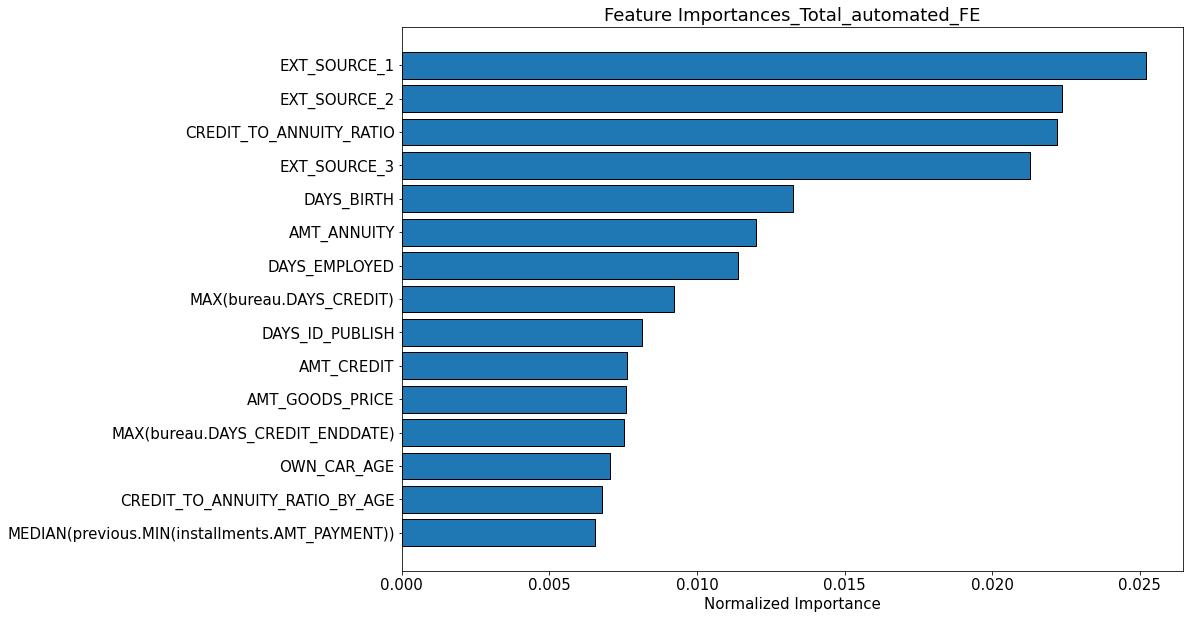

In [321]:
p7_functions.plot_feature_importances(fi_tot_aut_FE, 'Total_automated_FE')
plt.savefig('Feature Imp Total_automated_FE', dpi = 200, bbox_inches = 'tight') 
plt.show()

### Une nette amélioration du score AUC qui passe a (0.786637). Trois des features créés automatiquement par FT sont parmi les 15 features les plus importantes (en plus des 2 créés manuellement)

Cependant, nous avons un nombre important de features (2223 features). On va le réduire tout en testant comment cela affectera les résultats 

### 1- Supprimer les variables colinéaires 
Les variables colinéaires apportent la meme information au modele. On va supprimer les variables fortement corrélées (coefficient de corrélation > 0.9)

In [330]:
tot_aut_FE_col = feature_matrix_spec.drop(['TARGET', 'Test'], axis = 1)

In [332]:
tot_aut_FE_col.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 356244 entries, 100002.0 to 456250.0
Columns: 2221 entries, NAME_CONTRACT_TYPE to MODE(credit.previous.WEEKDAY_APPR_PROCESS_START)_WEDNESDAY
dtypes: bool(32), float64(1678), int32(18), uint8(493)
memory usage: 4.7 GB


In [333]:
%%time
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = tot_aut_FE_col.corr().abs()
corr_matrix.head()

Wall time: 1h 43min 12s


NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
NAME_CONTRACT_TYPE            1.000000     0.006560      0.004218   
CODE_GENDER                   0.006560     1.000000      0.343453   
FLAG_OWN_CAR                  0.004218     0.343453      1.000000   
FLAG_OWN_REALTY               0.063072     0.041575      0.002094   
CNT_CHILDREN                  0.028718     0.048284      0.103049   

                    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
NAME_CONTRACT_TYPE         0.063072      0.028718          0.004834   
CODE_GENDER                0.041575      0.048284          0.078524   
FLAG_OWN_CAR               0.002094      0.103049          0.089031   
FLAG_OWN_REALTY            1.000000      0.001898          0.004261   
CNT_CHILDREN               0.001898      1.000000          0.014081   

                    AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
NAME_CONTRACT_TYPE    0.200202     0.228320         0.166625   
CODE_GENDER           0.016904     0.076711         0.018230   
FLAG_OWN_CAR          0.117002     0.143532         0.121247   
FLAG_OWN_REALTY       0.034736     0.001609         0.042336   
CNT_CHILDREN          0.005982     0.025999         0.002235   

                    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
NAME_CONTRACT_TYPE                    0.023605    0.079416       0.034683   
CODE_GENDER                           0.013548    0.151359       0.092365   
FLAG_OWN_CAR                          0.039087    0.130528       0.022563   
FLAG_OWN_REALTY                       0.018165    0.117196       0.026771   
CNT_CHILDREN                          0.024206    0.329197       0.061682   

                    DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
NAME_CONTRACT_TYPE           0.019244         0.049422     0.010324   
CODE_GENDER                  0.077321         0.003334     0.003941   
FLAG_OWN_CAR                 0.087688         0.014983          NaN   
FLAG_OWN_REALTY              0.023871         0.007592     0.001013   
CNT_CHILDREN                 0.182221         0.027130     0.007878   

                    FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
NAME_CONTRACT_TYPE    0.000715        0.050981         0.032217   
CODE_GENDER           0.000800        0.157687         0.033437   
FLAG_OWN_CAR          0.003303        0.155241         0.012751   
FLAG_OWN_REALTY       0.001576        0.070654         0.130079   
CNT_CHILDREN          0.001363        0.240544         0.053155   

                    FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
NAME_CONTRACT_TYPE          0.107992    0.018819    0.022649         0.010692   
CODE_GENDER                 0.005451    0.020237    0.017446         0.080072   
FLAG_OWN_CAR                0.006727    0.006881    0.033019         0.151108   
FLAG_OWN_REALTY             0.006834    0.048382    0.039566         0.007281   
CNT_CHILDREN                0.001447    0.029816    0.024730         0.878906   

                    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
NAME_CONTRACT_TYPE              0.018429                     0.019668   
CODE_GENDER                     0.016739                     0.016089   
FLAG_OWN_CAR                    0.021726                     0.020697   
FLAG_OWN_REALTY                 0.000568                     0.000211   
CNT_CHILDREN                    0.023397                     0.022652   

                    HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
NAME_CONTRACT_TYPE                 0.033215                    0.016448   
CODE_GENDER                        0.006119                    0.023944   
FLAG_OWN_CAR                       0.013443                    0.001664   
FLAG_OWN_REALTY                    0.103652                    0.037900   
CNT_CHILDREN                       0.006156                    0.013523   

                    REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
NAME_CONTRACT_TYPE                    0.0141

In [334]:
%%time
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
upper.head()


Wall time: 65.8 ms


NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
NAME_CONTRACT_TYPE                 NaN      0.00656      0.004218   
CODE_GENDER                        NaN          NaN      0.343453   
FLAG_OWN_CAR                       NaN          NaN           NaN   
FLAG_OWN_REALTY                    NaN          NaN           NaN   
CNT_CHILDREN                       NaN          NaN           NaN   

                    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
NAME_CONTRACT_TYPE         0.063072      0.028718          0.004834   
CODE_GENDER                0.041575      0.048284          0.078524   
FLAG_OWN_CAR               0.002094      0.103049          0.089031   
FLAG_OWN_REALTY                 NaN      0.001898          0.004261   
CNT_CHILDREN                    NaN           NaN          0.014081   

                    AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
NAME_CONTRACT_TYPE    0.200202     0.228320         0.166625   
CODE_GENDER           0.016904     0.076711         0.018230   
FLAG_OWN_CAR          0.117002     0.143532         0.121247   
FLAG_OWN_REALTY       0.034736     0.001609         0.042336   
CNT_CHILDREN          0.005982     0.025999         0.002235   

                    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
NAME_CONTRACT_TYPE                    0.023605    0.079416       0.034683   
CODE_GENDER                           0.013548    0.151359       0.092365   
FLAG_OWN_CAR                          0.039087    0.130528       0.022563   
FLAG_OWN_REALTY                       0.018165    0.117196       0.026771   
CNT_CHILDREN                          0.024206    0.329197       0.061682   

                    DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
NAME_CONTRACT_TYPE           0.019244         0.049422     0.010324   
CODE_GENDER                  0.077321         0.003334     0.003941   
FLAG_OWN_CAR                 0.087688         0.014983          NaN   
FLAG_OWN_REALTY              0.023871         0.007592     0.001013   
CNT_CHILDREN                 0.182221         0.027130     0.007878   

                    FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
NAME_CONTRACT_TYPE    0.000715        0.050981         0.032217   
CODE_GENDER           0.000800        0.157687         0.033437   
FLAG_OWN_CAR          0.003303        0.155241         0.012751   
FLAG_OWN_REALTY       0.001576        0.070654         0.130079   
CNT_CHILDREN          0.001363        0.240544         0.053155   

                    FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
NAME_CONTRACT_TYPE          0.107992    0.018819    0.022649         0.010692   
CODE_GENDER                 0.005451    0.020237    0.017446         0.080072   
FLAG_OWN_CAR                0.006727    0.006881    0.033019         0.151108   
FLAG_OWN_REALTY             0.006834    0.048382    0.039566         0.007281   
CNT_CHILDREN                0.001447    0.029816    0.024730         0.878906   

                    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
NAME_CONTRACT_TYPE              0.018429                     0.019668   
CODE_GENDER                     0.016739                     0.016089   
FLAG_OWN_CAR                    0.021726                     0.020697   
FLAG_OWN_REALTY                 0.000568                     0.000211   
CNT_CHILDREN                    0.023397                     0.022652   

                    HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
NAME_CONTRACT_TYPE                 0.033215                    0.016448   
CODE_GENDER                        0.006119                    0.023944   
FLAG_OWN_CAR                       0.013443                    0.001664   
FLAG_OWN_REALTY                    0.103652                    0.037900   
CNT_CHILDREN                       0.006156                    0.013523   

                    REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
NAME_CONTRACT_TYPE                    0.0141

In [335]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 1166 columns to remove.


Il y a 1166 variables avec un coefficient de corrélation > 0.9! Supprimons-les et voir comment cela influencera les résultats

In [337]:
# Drop Correlated Variables
tot_aut_FE_col_del = feature_matrix_spec.drop(columns = to_drop)

print(tot_aut_FE_col_del.shape)


(356244, 1057)


### Test après avoir supprimé les variables colinéaires (coeff > 0.9):

In [338]:
%%time
train_aut_FE_col, test_aut_FE_col = p7_functions.get_train(tot_aut_FE_col_del)

Wall time: 1.82 s


In [341]:
test_aut_FE_col.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0    100001.0                 0.0          0.0           0.0              1.0   
1    100005.0                 0.0          1.0           0.0              1.0   
2    100013.0                 0.0          1.0           1.0              1.0   
3    100028.0                 0.0          0.0           0.0              1.0   
4    100038.0                 0.0          1.0           1.0              0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0           0.0          135000.0    568800.0      20560.5   
1           0.0           99000.0    222768.0      17370.0   
2           0.0          202500.0    663264.0      69777.0   
3           2.0          315000.0   1575000.0      49018.5   
4           1.0          180000.0    625500.0      32067.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018850    -19241.0        -2329.0            -5170.0   
1                    0.035792    -18064.0        -4469.0            -9118.0   
2                    0.019101    -20038.0        -4458.0            -2175.0   
3                    0.026392    -13976.0        -1866.0            -2000.0   
4                    0.010032    -13040.0        -2191.0            -4000.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0           -812.0          NaN        True            True            False   
1          -1623.0          NaN        True            True            False   
2          -3503.0          5.0        True            True            False   
3          -4208.0          NaN        True            True            False   
4          -4262.0         16.0        True            True             True   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0              True       False        True              2.0   
1              True       False       False              2.0   
2              True       False       False              2.0   
3              True        True       False              4.0   
4              True       False       False              3.0   

   REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                   2.0                     18.0                       False   
1                   2.0                      9.0                       False   
2                   2.0                     14.0                       False   
3                   2.0                     11.0                       False   
4                   2.0                      5.0                       False   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                   False                   False                    False   
1                   False                   False                    False   
2                   False                   False                    False   
3                   False                   False                    False   
4                   False                    True                     True   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.752614      0.789654      0.159520          0.0660            0.0590   
1      0.564990      0.291656      0.432962             NaN               NaN   
2           NaN      0.699787      0.610991             NaN               NaN   
3      0.525734      0.509677      0.612704          0.3052            0.1974   
4      0.202145      0.425687           NaN             NaN               

In [340]:
train_aut_FE_col = train_aut_FE_col.reset_index()
test_aut_FE_col = test_aut_FE_col.reset_index()

In [342]:
%%time
submission_aut_FE_col, fi_aut_FE_col, metrics_aut_FE_col = p7_functions.model(train_aut_FE_col, test_aut_FE_col)

Training Data Shape:  (307500, 1055)
Testing Data Shape:  (48744, 1055)
[200]	train's auc: 0.829447	train's binary_logloss: 0.515798	valid's auc: 0.784245	valid's binary_logloss: 0.534855
[400]	train's auc: 0.86766	train's binary_logloss: 0.472662	valid's auc: 0.786303	valid's binary_logloss: 0.507446
[600]	train's auc: 0.896129	train's binary_logloss: 0.437678	valid's auc: 0.786447	valid's binary_logloss: 0.484976
[200]	train's auc: 0.829433	train's binary_logloss: 0.516036	valid's auc: 0.781881	valid's binary_logloss: 0.532749
[400]	train's auc: 0.867704	train's binary_logloss: 0.472822	valid's auc: 0.783918	valid's binary_logloss: 0.505436
[200]	train's auc: 0.830018	train's binary_logloss: 0.515512	valid's auc: 0.781713	valid's binary_logloss: 0.536701
[400]	train's auc: 0.868222	train's binary_logloss: 0.47165	valid's auc: 0.78373	valid's binary_logloss: 0.508778
[200]	train's auc: 0.829352	train's binary_logloss: 0.515995	valid's auc: 0.783	valid's binary_logloss: 0.53781
[400]	t

In [343]:
metrics_aut_FE_col

fold     train     valid
0        0  0.892683  0.786685
1        1  0.873388  0.784179
2        2  0.875505  0.783929
3        3  0.866258  0.785467
4        4  0.872043  0.784076
5  overall  0.875975  0.784782

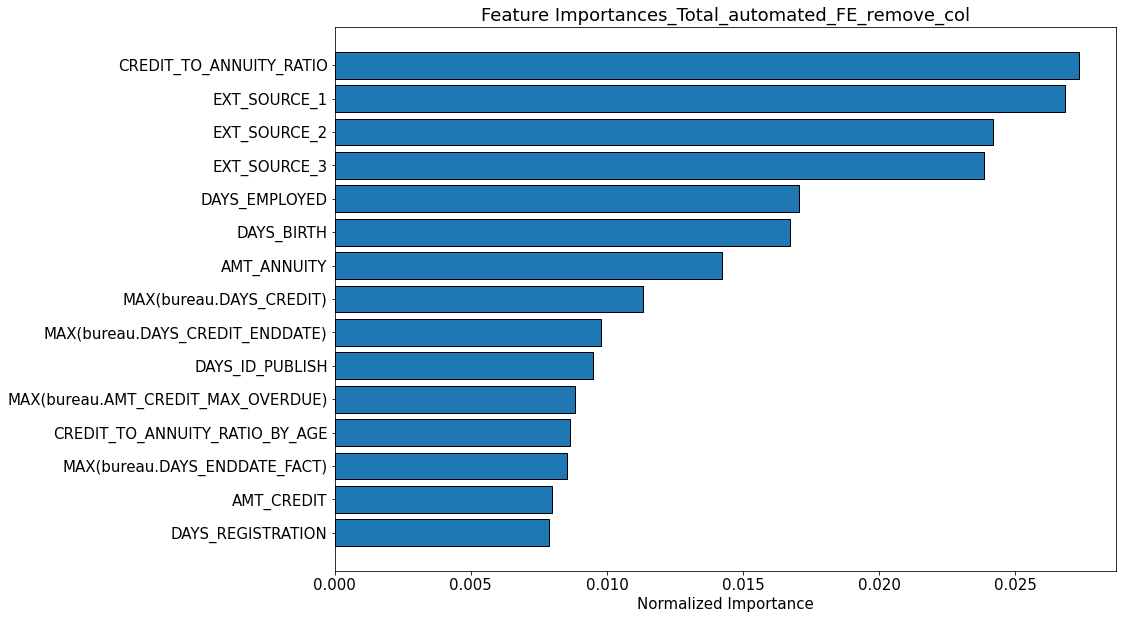

In [378]:
p7_functions.plot_feature_importances(fi_aut_FE_col, 'Total_automated_FE_remove_col')
plt.savefig('Feature Imp Total_automated_FE_remove_col', dpi = 200, bbox_inches = 'tight') 
plt.show()

Comme on peut le constater la suppression de plus de la moitié des features (avec une forte colinéarité) a légèrement affecté les résultats (AUC passe de 0.7866 à 0.784782) 

### 2- Supprimer les features avec des données manquantes importantes (> 80 %)

In [360]:
# Train missing values (in percent)
train_missing = (train_aut_FE_col.isnull().sum() / len(train_aut_FE_col)).sort_values(ascending = False)
# Test missing values (in percent)
test_missing = (test_aut_FE_col.isnull().sum() / len(test_aut_FE_col)).sort_values(ascending = False)


In [383]:
# Jeu d'entrainement
var_missing_values_train = list(train_missing[train_missing > 0.80].index)
# Jeu test
var_missing_values_test = list(test_missing[test_missing > 0.8].index)
# Concaténation des variables + suppression des doublons
var_missing_values = list(set(var_missing_values_train + var_missing_values_test))
print(f"There are {len(var_missing_values)} columns with more than 80% missing values. In train {len(var_missing_values_train)}, in test {len(var_missing_values_test)}")

There are 34 columns with more than 80% missing values. In train 34, in test 34


In [384]:
tot_aut_FE_col_del.shape

(356244, 1057)

In [385]:
# remove features > 0.8 missing value from the total df
tot_aut_FE_col_miss = tot_aut_FE_col_del.drop(columns = var_missing_values)
tot_aut_FE_col_miss.shape

(356244, 1023)

In [374]:
#Let's drop the columns >80% missing value

train_aut_FE_col_miss = train_aut_FE_col.drop(columns = var_missing_values)
test_aut_FE_col_miss = test_aut_FE_col.drop(columns = var_missing_values)

print('Training set full shape: ', train_aut_FE_col_miss.shape)
print('Testing set full shape: ' , test_aut_FE_col_miss.shape)


Training set full shape:  (307500, 1023)
Testing set full shape:  (48744, 1022)


### Test après avoir supprimé les variables avec plus de 80% de données manquantes

In [375]:
%%time
submission_aut_FE_col_miss, fi_aut_FE_col_miss, metrics_aut_FE_col_miss = p7_functions.model(train_aut_FE_col_miss, test_aut_FE_col_miss)

Training Data Shape:  (307500, 1021)
Testing Data Shape:  (48744, 1021)
[200]	train's auc: 0.829212	train's binary_logloss: 0.516036	valid's auc: 0.784412	valid's binary_logloss: 0.535345
[400]	train's auc: 0.867543	train's binary_logloss: 0.472425	valid's auc: 0.786395	valid's binary_logloss: 0.507861
[200]	train's auc: 0.829181	train's binary_logloss: 0.516183	valid's auc: 0.781822	valid's binary_logloss: 0.532691
[400]	train's auc: 0.867585	train's binary_logloss: 0.47273	valid's auc: 0.784576	valid's binary_logloss: 0.504764
[200]	train's auc: 0.830036	train's binary_logloss: 0.515461	valid's auc: 0.782733	valid's binary_logloss: 0.536779
[400]	train's auc: 0.868384	train's binary_logloss: 0.471953	valid's auc: 0.784706	valid's binary_logloss: 0.508611
[200]	train's auc: 0.829138	train's binary_logloss: 0.516391	valid's auc: 0.783379	valid's binary_logloss: 0.538642
[400]	train's auc: 0.866974	train's binary_logloss: 0.473148	valid's auc: 0.785933	valid's binary_logloss: 0.511325
[

In [376]:
metrics_aut_FE_col_miss

fold     train     valid
0        0  0.871561  0.786539
1        1  0.857187  0.784730
2        2  0.870106  0.784965
3        3  0.868112  0.785968
4        4  0.868848  0.784017
5  overall  0.867163  0.785230

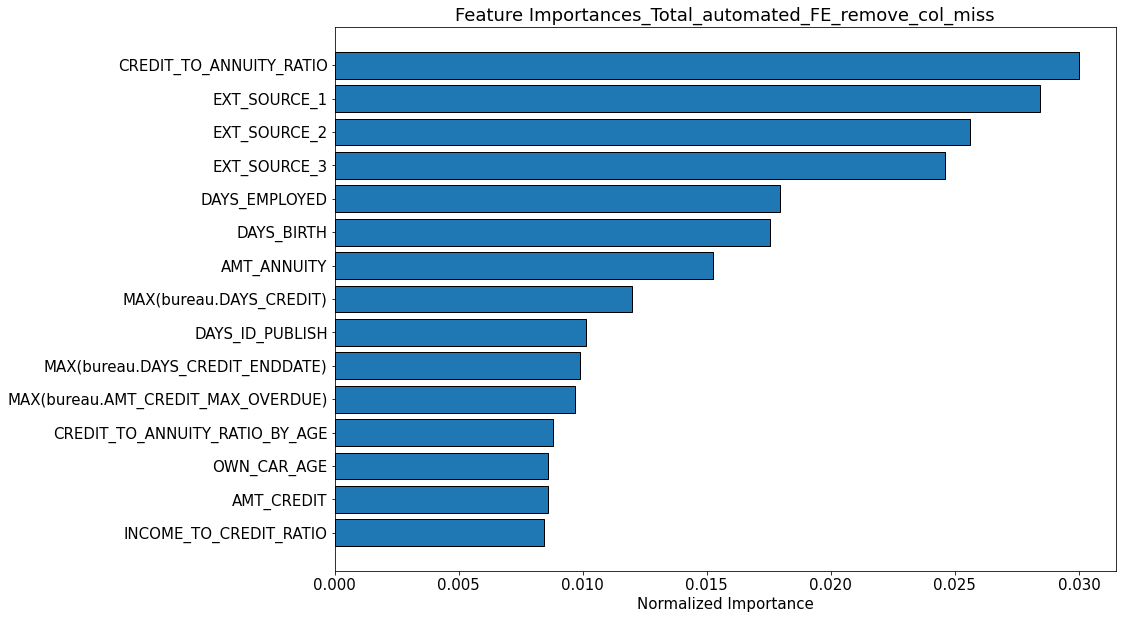

In [377]:
p7_functions.plot_feature_importances(fi_aut_FE_col_miss, 'Total_automated_FE_remove_col_miss')
plt.savefig('Feature Imp Total_automated_FE_remove_col_miss', dpi = 200, bbox_inches = 'tight') 
plt.show()

Pas d'impact note

### 3- Supprimer les features les moins importantes via FT

In [386]:
tot_aut_FE_col_miss.shape

(356244, 1023)

In [390]:
tot_aut_FE_col_miss_li = selection.remove_low_information_features(tot_aut_FE_col_miss)

print(f"Le nombre de colonnes supprime est de {len(tot_aut_FE_col_miss.columns)-len(tot_aut_FE_col_miss_li.columns)}")

Le nombre de colonnes supprime est de 5


In [389]:
tot_aut_FE_col_miss_li.shape

(356244, 1018)

Il n'y a que 5 features pas importantes selon FT

Le nombre des features a été bien réduit a 1018 features ce qui reste conséquent. Dans la suite, je vais procéder à éliminer les features avec zero importance pour le modèle utilisé qui est lightGBM et tester comment cela impactera les résultats. cette élimination pourrait éventuellement affecter la classification avec les autres modèles que je vais optimiser ultérieurement pour choisir le meilleur entre eux. Cependant, cette décision a été prise après avoir realisé un premier test rapide de plusieurs modèles selon lequel le modèle lightGBM s'est avéré le plus performant et le plus rapide (résultat non inclu dans ce notebook)

### 4- Supprimer les features avec zéro importance pour lightGBM

In [396]:
print(f"There are {sum(fi_aut_FE_col_miss['importance'] == 0.0)} features with 0 importance")

nul_imp = list(fi_aut_FE_col_miss['feature'].loc[fi_aut_FE_col_miss['importance'] == 0])


There are 271 features with 0 importance


In [397]:
# remove feature with zero importance zi
tot_aut_FE_col_miss_li_zi = tot_aut_FE_col_miss_li[tot_aut_FE_col_miss_li.columns.difference(nul_imp)]
tot_aut_FE_col_miss_li_zi.shape

(356244, 752)

### Test après avoir éliminé les 271 features de zéro importance

In [398]:
%%time
train_aut_FE_col_miss_li_zi, test_aut_FE_col_miss_li_zi = p7_functions.get_train(tot_aut_FE_col_miss_li_zi)


Wall time: 1.3 s


In [400]:
train_aut_FE_col_miss_li_zi.head()

AMT_ANNUITY  AMT_CREDIT  AMT_INCOME_TOTAL  \
SK_ID_CURR                                              
100002.0        24700.5    406597.5          202500.0   
100003.0        35698.5   1293502.5          270000.0   
100004.0         6750.0    135000.0           67500.0   
100006.0        29686.5    312682.5          135000.0   
100007.0        21865.5    513000.0          121500.0   

            AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
SK_ID_CURR                                                          
100002.0                          0.0                         0.0   
100003.0                          0.0                         0.0   
100004.0                          0.0                         0.0   
100006.0                          NaN                         NaN   
100007.0                          0.0                         0.0   

            AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
SK_ID_CURR                                                         
100002.0                          0.0                        0.0   
100003.0                          0.0                        0.0   
100004.0                          0.0                        0.0   
100006.0                          NaN                        NaN   
100007.0                          0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  \
SK_ID_CURR                                                           
100002.0                           0.0                         1.0   
100003.0                           0.0                         0.0   
100004.0                           0.0                         0.0   
100006.0                           NaN                         NaN   
100007.0                           0.0                         0.0   

            APARTMENTS_AVG  BASEMENTAREA_AVG  CNT_CHILDREN  CNT_FAM_MEMBERS  \
SK_ID_CURR                                                                    
100002.0            0.0247            0.0369           0.0              1.0   
100003.0            0.0959            0.0529           0.0              2.0   
100004.0               NaN               NaN           0.0              1.0   
100006.0               NaN               NaN           0.0              2.0   
100007.0               NaN               NaN           0.0              1.0   

            CODE_GENDER  COMMONAREA_AVG  COUNT(bureau)  COUNT(bureau_balance)  \
SK_ID_CURR                                                                      
100002.0            1.0          0.0143            8.0                  110.0   
100003.0            0.0          0.0605            4.0                    0.0   
100004.0            1.0             NaN            2.0                    0.0   
100006.0            0.0             NaN            0.0                    0.0   
100007.0            1.0             NaN            1.0                    0.0   

            COUNT(cash)  COUNT(credit)  COUNT(installments)  COUNT(previous)  \
SK_ID_CURR                                                                     
100002.0           19.0            0.0                 19.0              1.0   
100003.0           28.0            0.0                 25.0              3.0   
100004.0            4.0            0.0                  3.0              1.0   
100006.0           21.0            6.0                 16.0              9.0   
100007.0           66.0            0.0                 66.0              6.0   

            CREDIT_TO_ANNUITY_RATIO  CREDIT_TO_ANNUITY_RATIO_BY_AGE  \
SK_ID_CURR                                                            
100002.0                  16.461104                      426.680836   
100003.0                  36.234085                     1664.286145   
100004.0                  20.000000                     1043.616438   
100006.0                  10.532818                      548.427959   
100007.0                  23.461618                

In [401]:
train_aut_FE_col_miss_li_zi = train_aut_FE_col_miss_li_zi.reset_index()
test_aut_FE_col_miss_li_zi = test_aut_FE_col_miss_li_zi.reset_index()

In [405]:
%%time
submission_aut_FE_col_miss_li_zi, fi_aut_FE_col_miss_li_zi, metrics_aut_FE_col_miss_li_zi = p7_functions.model(train_aut_FE_col_miss_li_zi, test_aut_FE_col_miss_li_zi)

Training Data Shape:  (307500, 750)
Testing Data Shape:  (48744, 750)
[200]	train's auc: 0.829644	train's binary_logloss: 0.515792	valid's auc: 0.782748	valid's binary_logloss: 0.535398
[400]	train's auc: 0.86754	train's binary_logloss: 0.472604	valid's auc: 0.784348	valid's binary_logloss: 0.508215
[200]	train's auc: 0.829687	train's binary_logloss: 0.515835	valid's auc: 0.782745	valid's binary_logloss: 0.532398
[400]	train's auc: 0.867395	train's binary_logloss: 0.472961	valid's auc: 0.784635	valid's binary_logloss: 0.504853
[200]	train's auc: 0.829798	train's binary_logloss: 0.515445	valid's auc: 0.782702	valid's binary_logloss: 0.536157
[400]	train's auc: 0.867793	train's binary_logloss: 0.47232	valid's auc: 0.784807	valid's binary_logloss: 0.508666
[200]	train's auc: 0.828893	train's binary_logloss: 0.516515	valid's auc: 0.782592	valid's binary_logloss: 0.538913
[400]	train's auc: 0.866726	train's binary_logloss: 0.473437	valid's auc: 0.784546	valid's binary_logloss: 0.511564
[200

In [406]:
metrics_aut_FE_col_miss_li_zi 


fold     train     valid
0        0  0.872163  0.784638
1        1  0.878167  0.784986
2        2  0.872807  0.785045
3        3  0.874840  0.784642
4        4  0.868531  0.783889
5  overall  0.873301  0.784630

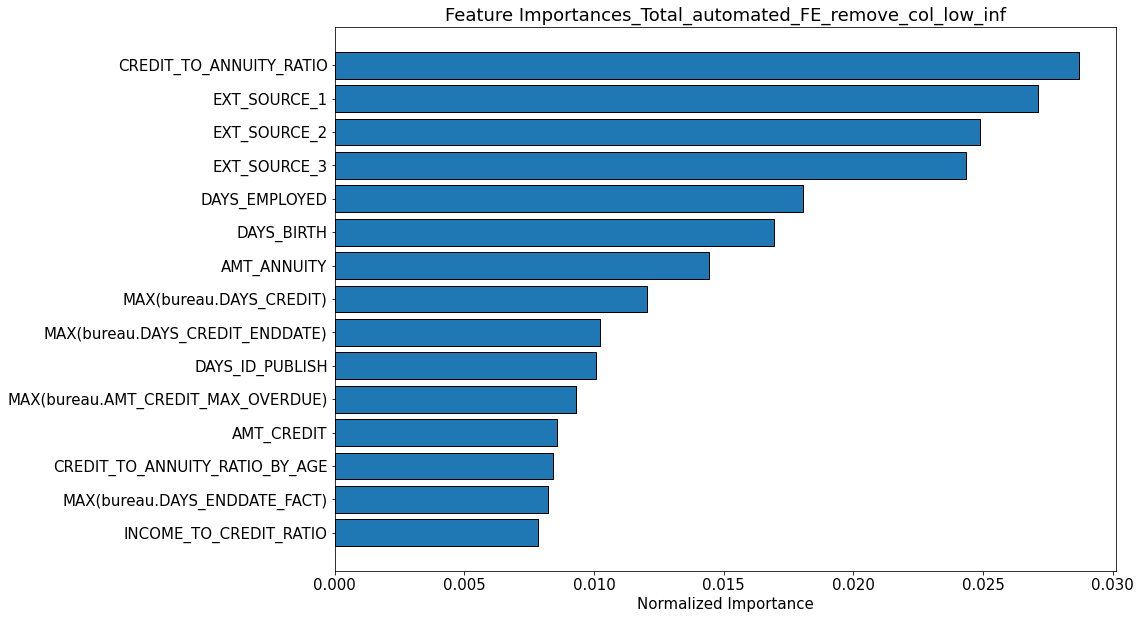

In [404]:
p7_functions.plot_feature_importances(fi_aut_FE_col_miss_li_zi, 'Total_automated_FE_remove_col_low_inf')
plt.savefig('Feature Imp Total_automated_FE_remove_col_low_inf', dpi=200, bbox_inches='tight') 
plt.show()

Avec les 4 étapes de réduction de dimensions qui nous ont permis d'éliminer 1471 des 2221 features, le score AUC a très légèrement diminue (de 0.7866 à 0.7846) qui est acceptable (peut etre pas pour une compétition!). 

In [407]:
%%time
# Sauvegarde des résultats
tot_aut_FE_col_miss_li_zi.to_csv("tot_aut_FE_col_miss_li_zi.csv", index = False)

Wall time: 1min 51s


# Modélisation

In [12]:
tot_enc = pd.read_csv('tot_aut_FE_col_miss_li_zi.csv')

In [20]:
tot_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356244 entries, 0 to 356243
Columns: 753 entries, SK_ID_CURR to YEARS_BUILD_AVG
dtypes: bool(19), float64(475), int64(259)
memory usage: 2.0 GB


In [15]:
train_tot, test_tot = p7_functions.get_train(tot_enc)

On va tester différents modèles avec optimisation d’hyperparamètres et cross validation. Pour réduire le temps de calcul, on va utiliser un échantillon de 16000 observations du jeu de données recupéré après le feature engineering train_tot : 10000 pour l’entrainement du modèle et 6000 pour le tester. Le fichier test_tot qui ne contient pas la cible TARGET sera utilisé dans la réalisation du dashboard 

L'échantillon est stratifié pour s'en assurer que nous avons les mêmes proportions des classe 0 et 1.

In [16]:
%%time

#define total sample size desired
N = 16000

#perform stratified random sampling
train_sample_str = train_tot.groupby('TARGET', group_keys = False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(train_tot))))).sample(frac = 1).reset_index(drop = True)

Wall time: 1.53 s


In [17]:
target_sample = train_sample_str["TARGET"].value_counts()
target_sample.values/target_sample.values.sum()*100

array([91.925,  8.075])

In [18]:
# Split into training and testing data
X_train_sample_str, X_test_sample_str = train_test_split(train_sample_str, test_size = 6000, random_state = 0)

In [19]:
X_train_sample_str["TARGET"].value_counts().values/X_train_sample_str["TARGET"].value_counts().values.sum()*100

array([91.67,  8.33])

In [20]:
X_test_sample_str["TARGET"].value_counts().values/X_test_sample_str["TARGET"].value_counts().values.sum()*100

array([92.35,  7.65])

In [21]:
X_test_sample_str.reset_index(inplace = True, drop = True)
X_train_sample_str.reset_index(inplace = True, drop = True)

In [22]:
%%time
# sample aleatoire stratifie, class_weight='balanced'
test_s_cw, fi_s_cw, metrics_s_cw = model_red(X_train_sample_str, X_test_sample_str, n_folds = 5)

Training Data Shape:  (10000, 750)
Testing Data Shape:  (6000, 750)
[200]	train's auc: 0.999994	train's binary_logloss: 0.107465	valid's auc: 0.682199	valid's binary_logloss: 0.32486
[400]	train's auc: 1	train's binary_logloss: 0.0287789	valid's auc: 0.683861	valid's binary_logloss: 0.312798
AUC-Test: 0.75143
Wall time: 49.2 s


In [136]:
%%time
# sample aleatoire stratifie, is_unbalance = True
test_s_unb, sub_s_cw, fi_s_unb, metrics_s_unb = model_red(X_train_sample_str, X_test_sample_str, n_folds = 5)

Training Data Shape:  (10000, 750)
Testing Data Shape:  (6000, 750)
AUC-Test: 0.70424
Wall time: 31.3 s


In [139]:
%%time
# sample aleatoire stratifie, is_unbalance = True, class_weight='balanced'
test_s_unb_cw, sub_s_unb_cw, fi_s_unb_cw, metrics_s_unb_cw = model_red(X_train_sample_str, X_test_sample_str, n_folds=5)

Training Data Shape:  (10000, 750)
Testing Data Shape:  (6000, 750)
AUC-Test: 0.68554
Wall time: 28.8 s


---------------------------------------------------------------------------------------------------
Entre (class_weight='balanced') et (is_unbalance = True) ou les 2 ensembles, le meilleur résultat obtenu avec (class_weight='balanced')

---------------------------------------------------------------------------------------------------

## Modélisation et comparaison des modèles 

Je vais tester plusieurs algorithmes :   
•  Logistic Regression   
•  Random Forest Classifier    
•  XGBoost     
•  LightGBM    
Pour chaque modèle, on va rechercher les valeurs optimales des hyperparamètres choisies en gridsearch selon la métrique AUC du fichier train cross validé (5 folds).      
Pour équilibrer les classes, on va utiliser SMOTE qui permet de créer des données synthétiques à partir des données existantes (oversampling). Pour éviter une éventuelle fuite des données, smote sera intégré dans une pipline de la librairie (Imbalanced-learn) dediée au classes deséquilibrées. Dans la même pipeline, une étape d'imputation des valeurs manquantes par la médiane de variable.   

### Logistic Regression

In [527]:
log_grid = {'classification__penalty': ['none', 'l2'],
        'classification__C': np.arange(0.005, 1.0, 0.01)}
logistic_reg = LogisticRegression(random_state = 0,verbose = 0)

In [528]:
%%time
gcv_log, score_log, best_log = p7_functions.imb_pipeline(logistic_reg, 'LogR', X_train_sample_str, X_test_sample_str, log_grid)

Training Data Shape:  (10000, 750)
Testing Data Shape:  (6000, 750)
{'classification__C': 0.09499999999999999, 'classification__penalty': 'none'}
{'mean_fit_time': array([13.21674514, 12.72797599, 12.79296808, 12.47017365, 12.78191004,
       12.66408505, 12.66420894, 12.89768662, 12.36368985, 12.48300843,
       12.69194736, 12.28030763, 12.52499814, 12.52540903, 12.3241138 ,
       12.90307136, 11.8999651 , 12.36008019, 12.51986804, 12.01953998,
       12.37772422, 12.15173674, 12.23135056, 12.57167168, 11.89869881,
       12.32594061, 12.23083391, 12.00540767, 12.28812342, 12.1485795 ,
       11.8858891 , 12.29931946, 11.98600998, 12.11534834, 11.93798432,
       12.03213696, 12.35461364, 11.93452697, 12.09458599, 12.2550014 ,
       12.00381751, 12.22617388, 11.89818387, 11.94485159, 12.05053859,
       11.94397283, 12.24214292, 11.91247945, 12.06079459, 11.97381496,
       12.20449343, 12.07855253, 11.83156676, 12.13498621, 12.11814418,
       12.16624217, 12.07377234, 11.97226143

In [529]:
score_log

[['LogR', 0.6292882083176862, 0.6135126660448443, 2124.443691968918]]

In [531]:
best_log

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampling', SMOTE()),
                ('classification',
                 LogisticRegression(C=0.09499999999999999, penalty='none',
                                    random_state=0))])

### Random Forest Classifier

In [524]:
rfc_grid = {'classification__n_estimators': [100, 300, 500], 'classification__max_depth':[1, 5, 10]
                      ,'classification__min_samples_split': [1, 5, 10], 'classification__min_samples_leaf':[1, 3, 5]} 
RFC = RandomForestClassifier(random_state = 0)

In [525]:
%%time
gcv_RFC, score_RFC, best_RFC = p7_functions.imb_pipeline(RFC, 'RFC', X_train_sample_str, X_test_sample_str, rfc_grid)

Training Data Shape:  (10000, 750)
Testing Data Shape:  (6000, 750)
{'classification__max_depth': 10, 'classification__min_samples_leaf': 5, 'classification__min_samples_split': 10, 'classification__n_estimators': 500}
{'mean_fit_time': array([  5.45634193,   5.331214  ,   5.48341827,   8.11841321,
        14.78957062,  20.36221156,   7.62066545,  14.54065914,
        20.96241822,   4.29883122,   4.65765362,   5.01008658,
         8.03890853,  14.29054122,  20.66880755,   7.49446154,
        14.44742746,  21.02680573,   4.20554652,   4.7633697 ,
         5.10284023,   8.17351871,  14.38007021,  20.82744908,
         7.61391592,  14.83180652,  20.96287813,   4.13005319,
         4.62780571,   5.07115707,  17.52200112,  42.0626039 ,
        67.83681946,  16.55843372,  42.08149409,  68.82708678,
         4.1164916 ,   4.25047736,   4.4711761 ,  16.65141554,
        42.02018952,  67.07176175,  16.68497257,  41.92466273,
        68.68181076,   4.08681612,   4.26884508,   4.40918312,
       

In [530]:
score_RFC

[['RFC', 0.7128939299127252, 0.6888713200151464, 1742.0176138877869]]

In [532]:
best_RFC

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampling', SMOTE()),
                ('classification',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=500,
                                        random_state=0))])

### XGBoost 

In [519]:
xgb_grid = {'classification__learning_rate': [0.05, 0.07, 0.08],
             'classification__max_depth': [5, 6, 7], 
             'classification__n_estimators':[100, 500, 1000] 
           }
XGBC = XGBClassifier(random_state = 0)

In [523]:
%%time
gcv_xgb, score_xgb, best_xgb = p7_functions.imb_pipeline(XGBC, 'XGB', X_train_sample_str, X_test_sample_str, xgb_grid)

Training Data Shape:  (10000, 750)
Testing Data Shape:  (6000, 750)
{'classification__learning_rate': 0.05, 'classification__max_depth': 7, 'classification__n_estimators': 1000}
{'mean_fit_time': array([ 239.94714704, 1077.48227272, 2102.33774991,  252.00059466,
       1249.38323793, 2447.99993711,  286.30044131, 1426.7747087 ,
       2723.13896265,  217.05740395, 1057.01073294, 2085.01630592,
        255.28791823, 1251.57602239, 2383.02989883,  291.72788401,
       1409.21052709, 2598.0056108 ,  217.96920352, 1059.41041865,
       2075.0338388 ,  255.73604951, 1245.23641191, 2349.62286177,
        291.67048173, 1357.54299846, 1986.98705072]), 'std_fit_time': array([ 1.51368962, 11.62378333,  6.53663432,  1.41166623,  5.25045769,
       11.76073123,  1.42083099,  3.45117644, 10.61137045,  0.86171844,
        2.71865368,  3.36357946,  1.1010557 ,  3.46607659, 11.45291003,
        0.95266666,  4.32505455, 15.3878194 ,  0.57747239,  3.2250728 ,
        5.57566055,  1.21776395,  2.36369818

In [533]:
best_xgb

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampling', SMOTE()),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.05, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=7, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                               pred

### Light GBM 

In [514]:
lgb_grid= {'classification__learning_rate': [0.05, 0.07, 0.08], 
             'classification__max_depth': [5, 6, 7], 
             'classification__n_estimators':[100, 500, 1000] 
           }
LGBM = LGBMClassifier(boosting_type = 'goss',
                             objective = 'binary',
                             reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 0)

In [515]:
%%time
gcv_lgb, score_lgb, best_lgb = p7_functions.imb_pipeline(LGBM, 'LGBM', X_train_sample_str, X_test_sample_str, lgb_grid)

Training Data Shape:  (10000, 750)
Testing Data Shape:  (6000, 750)
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampling', SMOTE()),
                ('classification',
                 LGBMClassifier(boosting_type='goss', learning_rate=0.08,
                                max_depth=6, objective='binary', random_state=0,
                                reg_alpha=0.1, reg_lambda=0.1))])
{'mean_fit_time': array([ 21.1220036 ,  74.33575225, 143.48856888,  30.38915453,
        94.66705256, 171.40837779,  34.28745332, 107.20267835,
       198.01907015,  24.81168299,  78.62688866, 158.73821688,
        33.75460258, 106.83593311, 193.58263011,  36.72742157,
       122.50692778, 208.44545403,  29.01209393,  87.5640831 ,
       161.18054743,  33.49946346, 108.67947683, 231.98780341,
        47.27515688, 154.48537893, 185.82997384]), 'std_fit_time': array([ 0.24276629,  3.33995133,  1.60705831,  1.04109123,  2.53986947,
        5.66045226,  0.44257787,  1.872

### Comparaison best modèles 

In [601]:
%%time
best_classifiers = [('Dummy Classifier', DummyClassifier()),
                  ('Logistic Regression', best_log),
                  ('Random Forest', best_RFC),
                  ('Xgboost', best_xgb),
                  ('LGBM', best_lgb)
                   ]

all_scores = {}
   
for classifier in best_classifiers:
    print(f"Working on {classifier[0]}")
    
    cv, scores, mean = p7_functions.imb_best_class(classifier[1], classifier[0], X_train_sample_str, X_test_sample_str)
    
    print(f"CV for {classifier[0]} is {cv}")
    print(f"mean AUC score for {classifier[0]} is {mean}")
    print('-'*50)
    print(f"AUC all folds score for {classifier[0]} is {scores}")
    print('-'*50)
    print('\n')
    all_scores[classifier[0]] = [mean, cv['fit_time'].mean()]
   

Working on Dummy Classifier
Training Data Shape:  (10000, 750)
Testing Data Shape:  (6000, 750)
CV for Dummy Classifier is {'fit_time': array([0.0484755 , 0.05599856, 0.0475955 , 0.0484755 , 0.0484755 ]), 'score_time': array([0.        , 0.00381351, 0.        , 0.        , 0.        ]), 'test_score': array([0.5, 0.5, 0.5, 0.5, 0.5]), 'train_score': array([0.5, 0.5, 0.5, 0.5, 0.5])}
mean AUC score for Dummy Classifier is 0.5
--------------------------------------------------
AUC all folds score for Dummy Classifier is [0.5 0.5 0.5 0.5 0.5]
--------------------------------------------------


Working on Logistic Regression
Training Data Shape:  (10000, 750)
Testing Data Shape:  (6000, 750)
CV for Logistic Regression is {'fit_time': array([8.91857195, 8.87728572, 8.95557404, 8.8884263 , 8.72326827]), 'score_time': array([0.24263525, 0.24161339, 0.23596311, 0.24257469, 0.34127855]), 'test_score': array([0.6396902 , 0.61272832, 0.61562831, 0.61727759, 0.63836776]), 'train_score': array([0.6

In [602]:
 all_scores

{'Dummy Classifier': [0.5, 0.04980411529541016],
 'Logistic Regression': [0.621230547739396, 8.872625255584717],
 'Random Forest': [0.7097094339132668, 82.99701433181762],
 'Xgboost': [0.7454879939943354, 19.372451734542846],
 'LGBM': [0.7468469614307847, 19.242965269088746]}

In [633]:
df_all_scores = pd.DataFrame(index = all_scores.keys(), columns = ['mean_AUC','mean_fit_time'])
for index, key in enumerate(all_scores):
    df_all_scores.iloc[index]['mean_AUC'] = all_scores[key][0]
    df_all_scores.iloc[index]['mean_fit_time'] = all_scores[key][1]
df_all_scores.reset_index(inplace = True)

In [634]:
df_all_scores = df_all_scores.rename(columns = {'index':'model'})

In [668]:
df_all_scores['mean_fit_time_norm'] = df_all_scores['mean_fit_time']/df_all_scores['mean_fit_time'].max()

In [669]:
df_all_scores

model  mean_AUC mean_fit_time mean_fit_time_norm
0     Dummy Classifier       0.5      0.049804             0.0006
1  Logistic Regression  0.621231      8.872625           0.106903
2        Random Forest  0.709709     82.997014                1.0
3              Xgboost  0.745488     19.372452           0.233411
4                 LGBM  0.746847     19.242965           0.231851

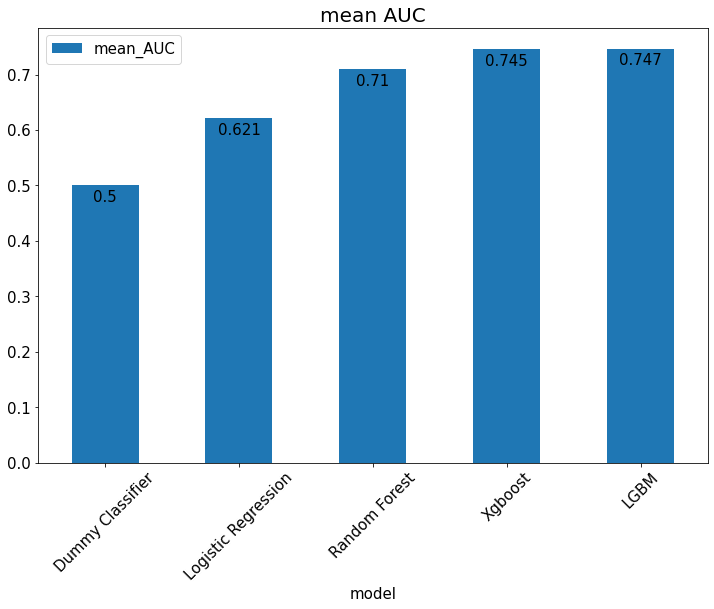

In [34]:
plot = df_all_scores.plot.bar(y = ['mean_AUC'], x = 'model', figsize = (12,8), fontsize = 15)
plt.title('mean AUC', fontsize = 0)
plt.ylabel('')
plt.xticks(rotation = 45)
for p in plot.patches :
    #for i in range(len(plot.patches)):
            plot.annotate(round(p.get_height(), 3), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size = 15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')
plt.savefig('all_modl_mean_best_valid_AUC', dpi = 200, bbox_inches = 'tight')
plt.show()

Dummy Classifier
Logistic Regression
Random Forest
Xgboost
LGBM


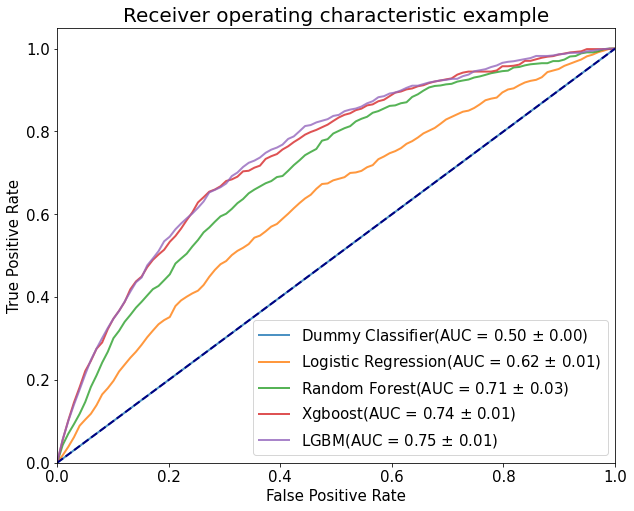

<Figure size 720x576 with 0 Axes>

In [785]:
plot_roc_curve(best_classifiers, X_train_sample_str.drop(columns = "TARGET"), X_train_sample_str["TARGET"], n_splits = 5, fit = True)
plt.savefig('ROC sample 10000 4 modeles optimises-smote', dpi = 200, bbox_inches = 'tight') 
plt.show()

### Le modèle lightGBM est le plus performant donc on va le retenir pour la classification. Dans la suite, je vais réaliser un fine tuning des hyperparamètres avec hyperopt

## Lightgbm : hyperopt fine tuning

In [80]:
# total train : split le jeu d'entrainement en entrainement et test
train_set, valid_set = train_test_split(train_tot, test_size = 0.2, random_state = 0)

In [81]:
train_set.reset_index(inplace = True, drop = True)
valid_set.reset_index(inplace = True, drop = True)
print(f"train : {train_set['TARGET'].value_counts().values/train_set['TARGET'].value_counts().values.sum()*100}")
print(f"valid : {valid_set['TARGET'].value_counts().values/valid_set['TARGET'].value_counts().values.sum()*100}")

train : [91.95406504  8.04593496]
valid : [91.82113821  8.17886179]


### Entrainer LGBM sur toutes les données

In [1218]:
%%time
valid_auc, fi_tot, metrics_tot = model_red(train_set, valid_set, n_folds = 5)

Training Data Shape:  (246000, 750)
Testing Data Shape:  (61500, 750)
[200]	train's auc: 0.838525	train's binary_logloss: 0.507086	valid's auc: 0.781205	valid's binary_logloss: 0.535028
[400]	train's auc: 0.881979	train's binary_logloss: 0.456514	valid's auc: 0.783459	valid's binary_logloss: 0.502752
[200]	train's auc: 0.839478	train's binary_logloss: 0.505587	valid's auc: 0.778337	valid's binary_logloss: 0.531954
[400]	train's auc: 0.88295	train's binary_logloss: 0.455002	valid's auc: 0.778982	valid's binary_logloss: 0.499687
[200]	train's auc: 0.83893	train's binary_logloss: 0.506731	valid's auc: 0.784371	valid's binary_logloss: 0.528079
[200]	train's auc: 0.838318	train's binary_logloss: 0.507556	valid's auc: 0.783002	valid's binary_logloss: 0.531516
[400]	train's auc: 0.881922	train's binary_logloss: 0.456884	valid's auc: 0.785231	valid's binary_logloss: 0.498195
[200]	train's auc: 0.839088	train's binary_logloss: 0.506478	valid's auc: 0.781233	valid's binary_logloss: 0.528013
[400

In [1340]:
metrics_tot

fold     train     valid
0        0  0.889847  0.783684
1        1  0.877585  0.779202
2        2  0.861940  0.785893
3        3  0.881922  0.785231
4        4  0.877598  0.782953
5  overall  0.877778  0.783363

### Optimisation avec hyperopt selon la métrique AUC

In [72]:
# lightGBM
LGBMC = LGBMClassifier(boosting_type = 'goss',
                       objective = 'binary',
                      class_weight = 'balanced',
                    reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 0)

In [86]:
# Optimisation pour la métrique 'roc_auc'
best_parameters_lgb_rauc_tot, feature_importance_lgb_rauc_tot, lgb_rauc_tot = model_v1(LGBMC, 
                                                                                       train_set,
                                                                                       eval_metric = roc_auc_score)

100%|███████████████████████████████████████████| 10/10 [6:26:16<00:00, 2317.62s/trial, best loss: 0.33595143501659663]


In [122]:
best_parameters_lgb_rauc_tot

{'classification__colsample_by_tree': 0.6000000000000001,
 'classification__learning_rate': 0.12309027383864302,
 'classification__max_depth': 6.0,
 'classification__n_estimators': 600.0,
 'classification__num_leaves': 20.0,
 'classification__solvability_threshold': 0.15000000000000002,
 'classification__subsample': 0.2}

In [93]:
# Sauvegarde du modèle auc total sample
output =  open('auc_lgb_bank_tot', 'wb')
pickle.dump(lgb_rauc_tot, output)
output.close()

In [111]:
lgb_rauc_tot

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampling', SMOTE(random_state=0)),
                ('classification',
                 LGBMClassifier(boosting_type='goss', class_weight='balanced',
                                colsample_bytree=0.6000000000000001,
                                learning_rate=0.12309027383864302, max_depth=6,
                                n_estimators=600, num_leaves=20,
                                objective='binary', random_state=0,
                                reg_alpha=0.1, reg_lambda=0.1,
                                subsample=0.2))])

### Prédiction sur les données de validation pour le modèle optimisé avec la métrique AUC

In [89]:
y_proba_auc = lgb_rauc_tot.steps[2][1].predict_proba(valid_set.drop(columns = ['SK_ID_CURR',"TARGET"]))[:, 1]
y_pred_auc = (y_proba_auc > best_parameters_lgb_rauc_tot['classification__solvability_threshold'])
y_pred_auc = np.array(y_pred_auc > 0) * 1

### Optimisation selon une métrique métier

La métrique métier consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données pour limiter les pertes financières autant que possible. Du point de vue d’une banque, on cherche donc à éviter de mal catégoriser un client avec un fort risque de défaut (pertes financières importantes) càd on cherche à minimiser le pourcentage de faux négatifs (FN) et à maximiser le pourcentage de vrais négatifs  ici càd les clients solvables (TN).

Dans ce contexte, on va fixer un poids arbitraire pour chacune des prédictions relativement à leurs valeurs réelles comme suivant :

- fn_value = -10
- tp_value = 0
- tn_value = 1
- fp_value = 0

De ce fait, les prêts accordés aux clients qui sont non-solvables (défaillants) sont pénalisés de -10x, alors que les prêts accordés aux clients solvables rapportent x1. Ce rapport de 10 est choisi arbitrairement. On pourrait éventuellement utliser une valeur proposée par des experts métier pour l'opimisation des hyperparamètres à leur convenance métier en vue du gain prédéfini. 


In [149]:
## Définition de la métrique métier 

def metric_metier(y_true, y_pred, fn_value = -10, fp_value = 0, tp_value = 0, tn_value = 1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    return J_normalized  # Retourne la fonction d'évaluation

In [1323]:
best_parameters_lgb_bank_tot, feature_importance_lgb_bank_tot, clf_lgb_bank_tot= model_v1(LGBMC, train_set, eval_metric = metric_metier)

In [1225]:
clf_lgb_bank_tot

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampling', SMOTE(random_state=0)),
                ('classification',
                 LGBMClassifier(boosting_type='goss',
                                learning_rate=0.05373171012333143, max_depth=20,
                                n_estimators=1000, num_leaves=32,
                                objective='binary', random_state=0,
                                reg_alpha=0.1, reg_lambda=0.1,
                                subsample=0.4))])

In [1319]:
best_parameters_lgb_bank_tot

{'classification__learning_rate': 0.05373171012333143,
 'classification__max_depth': 20.0,
 'classification__n_estimators': 1000.0,
 'classification__num_leaves': 32.0,
 'classification__solvability_threshold': 0.1,
 'classification__subsample': 0.4}

In [1229]:
# Sauvegarde du modèle banking total sample
output =  open('clf_lgb_bank_tot', 'wb')
pickle.dump(clf_lgb_bank_tot, output)
output.close()

In [1262]:
lgb_tot_bank = pickle.load(open('clf_lgb_bank_tot', 'rb'))
lgb_tot_bank

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampling', SMOTE(random_state=0)),
                ('classification',
                 LGBMClassifier(boosting_type='goss',
                                learning_rate=0.05373171012333143, max_depth=20,
                                n_estimators=1000, num_leaves=32,
                                objective='binary', random_state=0,
                                reg_alpha=0.1, reg_lambda=0.1,
                                subsample=0.4))])

#### Prédiction sur les données de validation pour le modèle optimisé selon la métrique métier

In [74]:
cls_lgb_bank = pickle.load(open('lgb_bank_tot', 'rb'))
cls_lgb_bank

LGBMClassifier(boosting_type='goss', learning_rate=0.036493092410165025,
               max_depth=14, n_estimators=600, num_leaves=60,
               objective='binary', random_state=0, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.8)

In [91]:
y_proba_metier = cls_lgb_bank.predict_proba(valid_set.drop(['SK_ID_CURR',"TARGET"], axis=1))[:, 1]
y_pred_metier = (y_proba_metier > best_parameters_lgb_bank_tot['classification__solvability_threshold'])
y_pred_metier_arr = np.array(y_pred_metier > 0) * 1

In [ ]:
 plot_heatmap_confusion(y_valid, **y_valid_pred)

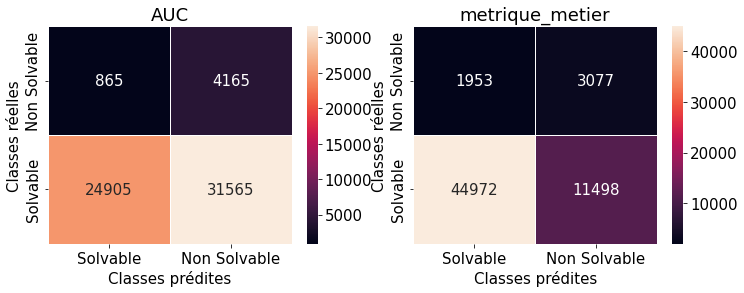

In [148]:
mat_conf_tot = plot_heatmap_confusion(valid_set["TARGET"],
                       **{"AUC": y_pred_auc, "metrique_metier": y_pred_metier})
plt.savefig('matrice de confusion AUC et metier', dpi = 200, bbox_inches = 'tight') 
plt.show()


Avec la métrique métier, nous n'avons pas pu diminuer le nombre des FN mais les TN sont considérablement augmentés. On va calculer le gain pour évaluer la contribution de la fonction cout métier

## Estimation du gain avec les résultats AUC et la métrique métier

In [150]:
# Calcul du gain pour la métrique bancaire
J_0 = metric_metier(valid_set["TARGET"], y_pred_metier)
# Calcul du gain pour la métrique AUC
J_1 = metric_metier(valid_set["TARGET"], y_pred_auc)
#J_2 = metric_metier(valid_set["TARGET"], y_pred_f1)
print(f"Le gain normalisé pour la métrique banking est de {J_0:.2f} alors qu'il est de {J_1:.2f} pour la métrique technique AUC")
    
print("La création de la métrique métier permet un gain de {:.1f}%".format(100*(J_0 - J_1)/J_0))
print('---------------------------------------------------------------------------------------------------')


Le gain normalisé pour la métrique banking est de 0.71 alors qu'il est de 0.62 pour la métrique technique AUC
La création de la métrique métier permet un gain de 12.1%
---------------------------------------------------------------------------------------------------


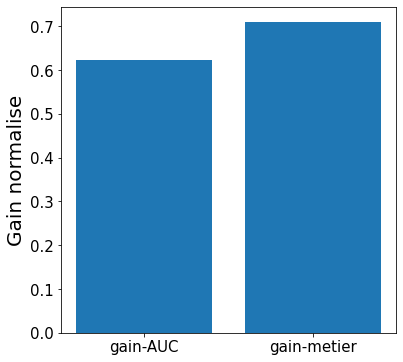

In [144]:
data = {'gain-AUC':J_1, 'gain-metier':J_0}
gains = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (6, 6))
 
# creating the bar plot
plt.bar(gains, values) 
plt.xlabel("")
plt.ylabel("Gain normalise", fontsize = 20)
#plt.title("Gains optimisation hyperparametres selon score AUC et score metier")
plt.savefig('gain AUC et metier', dpi = 200, bbox_inches = 'tight') 
plt.show()

In [100]:
valid_set['TARGET'].value_counts().values

array([56470,  5030], dtype=int64)

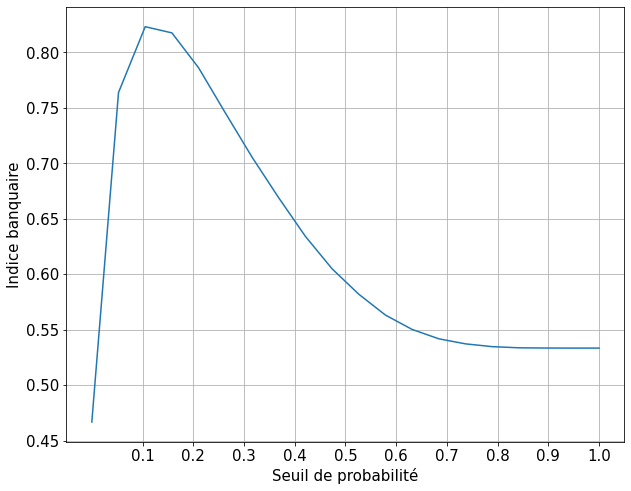

In [154]:
p7_functions.gain_seuil(cls_lgb_bank, train_set.drop(columns = ['SK_ID_CURR',"TARGET"]), train_set["TARGET"])
plt.savefig('gain seuil metier', dpi = 200, bbox_inches = 'tight') 
plt.show()

On retrouve le fait que le meilleur seuil de solvabilité est de 0.1 comme celui trouvé par l'optimisation via hyperopt.

Le gain obtenu avec un seuil de 0.1 est plus conséquent que pour un seuil par défaut de 0.5 fixé par LGBM

# Global feature importance

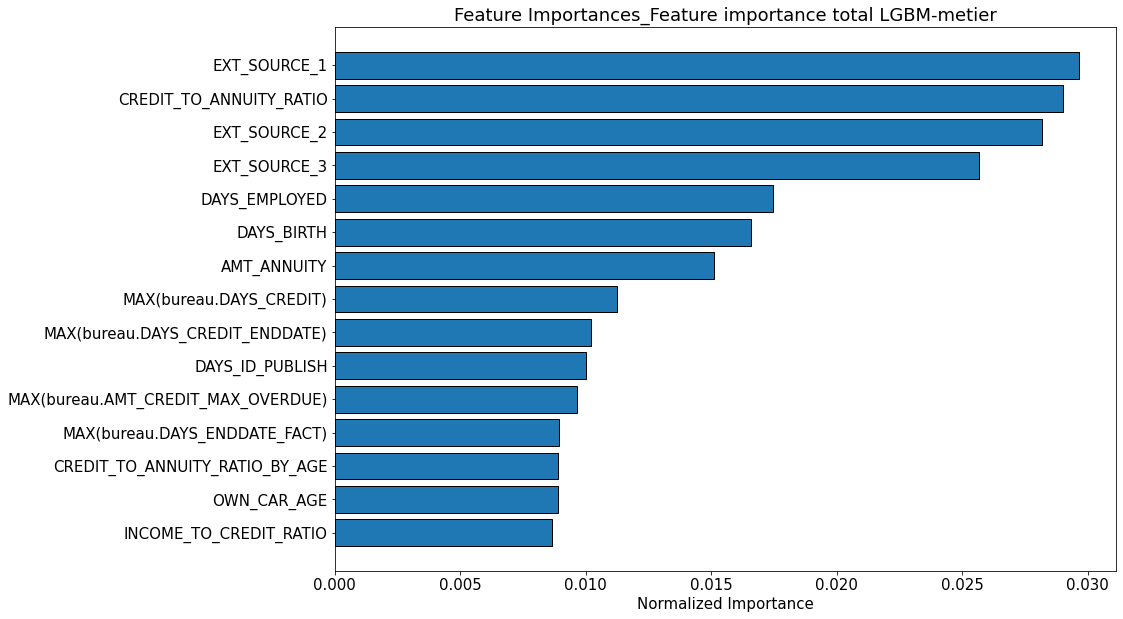

In [1458]:
p7_functions.plot_feature_importances(feature_importance_lgb_bank_tot, 'Feature importance total LGBM-metier')
plt.savefig('Feature Imp Tout fichier_lgbm hyperopt metier', dpi = 200, bbox_inches = 'tight') 
plt.show()

Parmi les 15 features les plus importantes, la moitié a été créée dans l'étape feature engineering (manuellement et automatiquement)   

Les données externes : EXT_SOURCE_ sont au top de la liste (on n'a pas d’infos sur ces variables)

In [ ]:
# Sauvegarde global features importances total 
feature_importances_opt_lgbtot_bal.sort_values(by = 'importance', ascending = False).to_pickle('glob_FI_bank_tot.pickle')

## Interprétation locale : SHAP

La méthode SHAP (SHapley Additive exPlanations) consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.
La somme des effets de chaque variable expliquera la prédiction.
Grâce à la valeur de Shap, on peut déterminer la contribution des différentes variables d’une prédiction pour un modèle qui explique l’écart de cette prédiction par rapport à la valeur de base.  
source : https://www.kaggle.com/code/dansbecker/shap-values/tutorial

In [156]:
x_train = train_set.drop(columns = ['SK_ID_CURR',"TARGET"])
x_test = valid_set.drop(columns = ['SK_ID_CURR',"TARGET"])

In [159]:
%%time
explainer = shap.TreeExplainer(cls_lgb_bank)
shap_values = explainer.shap_values(x_test)
shap_vals = explainer(x_test)

Wall time: 12min 27s


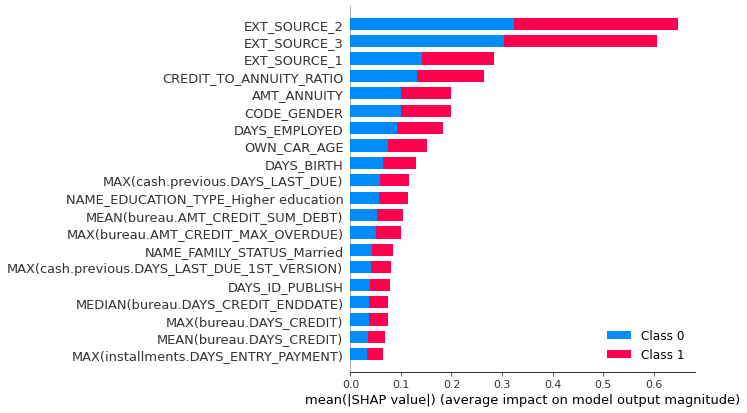

In [162]:
# Summary plot
shap.summary_plot(shap_values, x_test, show = False, plot_size = [10,6])
plt.savefig('shap summary plot mean 2 classes-tot', dpi = 200, bbox_inches = 'tight') 
plt.show()

summary plot from the shap values generated for class 1 from test data

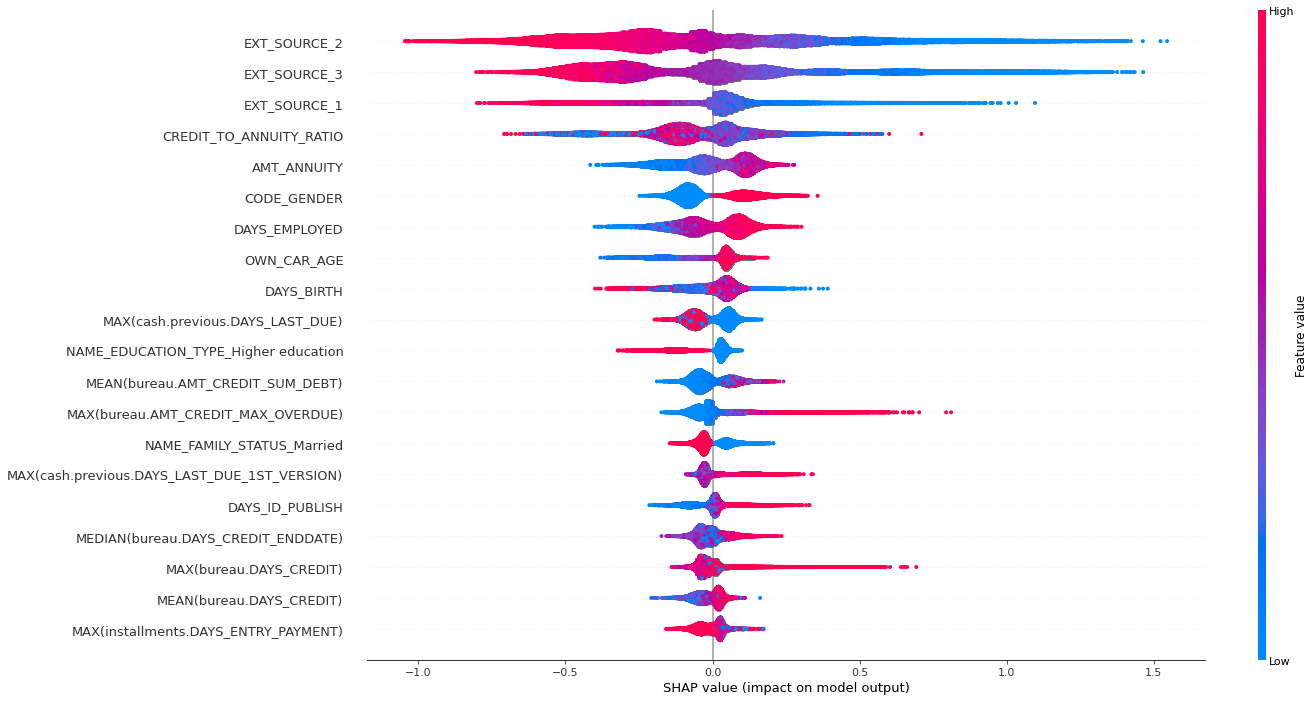

In [163]:
shap.summary_plot(shap_values[1],x_test, show=False, plot_size=[20,10])
plt.savefig('shap summary plot classe1', dpi=200, bbox_inches='tight') 
plt.show()

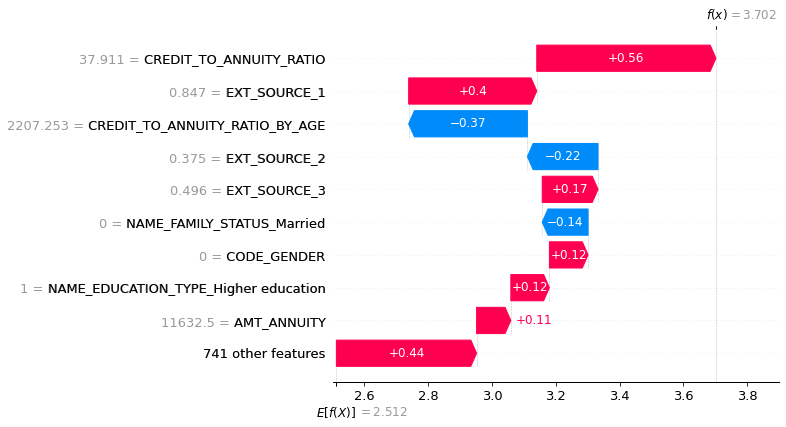

In [169]:
# shap local pour un client
shap.waterfall_plot(shap_vals[2][:, 0],show = False)
plt.savefig('shap client 0 valid set tot', dpi = 200, bbox_inches = 'tight') 
plt.show()

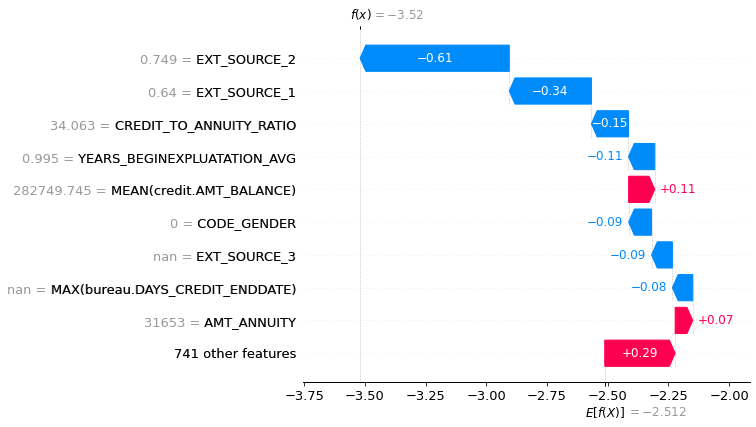

In [168]:
# shap local pour un client
shap.waterfall_plot(shap_vals[10][:, 1],show = False)
plt.savefig('shap client 10 valid set tot', dpi = 200, bbox_inches = 'tight') 
plt.show()

Comme on a pu constater que SHAP nous montre la contribution globale des caractéristiques et aussi la contribution locale de ces caractéristiques c’est-à-dire pour une prédiction (pour un client) comme les courbes waterfall le montrent

La courbe waterfall commence sur l'axe des X par la valeur attendue du modèle (E(f(X))), puis chaque ligne montre comment la contribution est positive (rouge) ou négative (bleue) de chaque caractéristique déplace cette valeur vers la valeur prédite pour cette observation.
